In [7]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["SM_FRAMEWORK"] = "tf.keras"

import sys
sys.path.append('../src/')

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger
import segmentation_models as sm
import keras
import numpy as np
import matplotlib.pyplot as plt

from data.dataloader import Dataloder
from data.dataset import Dataset
from data.data_utils import get_validation_augmentation,get_preprocessing,get_training_augmentation
from visualization.viz_utils import visualize, denormalize



keras.utils.set_random_seed(812)

In [8]:
DATA_DIR = '../data/raw/'
PATH_MODELS = "../models/"
PATH_LOGS = "../logs/"
RESULTS_PATH = "../results/"

# define os paths dos dados
x_train_dir = os.path.join(DATA_DIR, 'training', 'input')
y_train_dir = os.path.join(DATA_DIR, 'training', 'target')

x_test_dir = os.path.join(DATA_DIR, 'test', 'input')
y_test_dir = os.path.join(DATA_DIR, 'test', 'target')


# Gerar lista de IDs
train_ids = ['%02d' % i for i in range(21, 41)]
test_ids = ['%02d' % i for i in range(1, 21)]

# Dividir IDs de treinamento em conjuntos de treinamento e validação
val_ids = train_ids[-4:]
train_ids = train_ids[:-4]

BACKBONE = 'efficientnetb3'
BATCH_SIZE = 4
LR = 0.0001
EPOCHS = 100000
n_classes = 1
activation = 'sigmoid'

In [9]:
preprocess_input = sm.get_preprocessing(BACKBONE)
# Criar modelo
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)
# Definir otimizador
optim = keras.optimizers.Adam(LR)

# Definir perda e métricas
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), 'accuracy', 'precision', 'recall']

In [15]:
# Compilar modelo
model.compile(optimizer=optim, loss=total_loss, metrics=metrics)

In [17]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │      1,080 │ input_layer_1[0]… │
│                     │ None, 40)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 40)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 40)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, None,      │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ None, 40)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, None,      │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ None, 40)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, None,      │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ None, 40)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, None,      │          0 │ block1a_activati… │
│ (Multiply)          │ None, 40)         │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │        960 │ block1a_se_excit… │
│ (Conv2D)            │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         96 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_dwconv      │ (None, None,      │        216 │ block1a_project_… │
│ (DepthwiseConv2D)   │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_bn          │ (None, None,      │         96 │ block1b_dwconv[0… │
│ (BatchNormalizatio… │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_activation  │ (None, None,      │          0 │ block1b_bn[0][0]

 Total params: 17,867,833 (68.16 MB)

 Trainable params: 17,778,553 (67.82 MB)

 Non-trainable params: 89,280 (348.75 KB)

In [12]:
# Dataset para imagens de treinamento
train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    ids=train_ids,
    dataset_name='training',
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)


# Dataset para imagens de validação
valid_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    ids=val_ids,
    dataset_name='training',
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset para imagens de teste
test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
    ids=test_ids,
    dataset_name='test',
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)
test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

# Verificar formas para erros
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, n_classes)



model_weights = PATH_MODELS + 'weights/best_model.weights.h5'

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10),
    ModelCheckpoint(PATH_MODELS + f'model_file/best_model.keras', save_best_only=True, monitor='val_loss'),
    ModelCheckpoint(model_weights, save_weights_only=True, save_best_only=True, mode='min'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
    TensorBoard(log_dir=PATH_LOGS),
    CSVLogger(PATH_MODELS + f'training_log.csv')
]

# Treinar modelo
history = model.fit(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=valid_dataloader,
    validation_steps=len(valid_dataloader),
)

Epoch 1/100000


/home/semcovici/pesquisa/segmentation-of-blood-vessels-in-retinal-images/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726457595.562704 1599937 service.cc:146] XLA service 0x7dc370007540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726457595.562727 1599937 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-09-16 00:33:17.548870: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-16 00:33:25.249895: I external/local_xla/xla/stream_executor/cud

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7575 - f1-score: 0.1747 - iou_score: 0.0958 - loss: 0.9447 - precision: 0.1256 - recall: 0.2878

E0000 00:00:1726457681.431331 1599937 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1726457681.552825 1599937 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-09-16 00:34:43.722942: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.94GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-09-16 00:34:44.182611: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.59GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more mem

4/4 ━━━━━━━━━━━━━━━━━━━━ 157s 6s/step - accuracy: 0.7579 - f1-score: 0.1770 - iou_score: 0.0972 - loss: 0.9439 - precision: 0.1269 - recall: 0.2939 - val_accuracy: 0.1472 - val_f1-score: 0.1575 - val_iou_score: 0.0855 - val_loss: 1.3421 - val_precision: 0.0859 - val_recall: 0.9536 - learning_rate: 1.0000e-04
Epoch 2/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/100000


2024-09-16 00:34:53.068369: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-16 00:34:53.068686: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-09-16 00:34:53.151496: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-09-16 00:34:53.151536: I tensorflow/core/framework/local_rendezvous.cc:423] Lo

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.7761 - f1-score: 0.2578 - iou_score: 0.1480 - loss: 0.9064 - precision: 0.1830 - recall: 0.4357 - val_accuracy: 0.1457 - val_f1-score: 0.1608 - val_iou_score: 0.0875 - val_loss: 1.3595 - val_precision: 0.0876 - val_recall: 0.9792 - learning_rate: 1.0000e-04
Epoch 4/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/100000


2024-09-16 00:34:54.297172: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-09-16 00:34:54.297206: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:34:54.297214: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.7958 - f1-score: 0.3340 - iou_score: 0.2006 - loss: 0.8747 - precision: 0.2377 - recall: 0.5615 - val_accuracy: 0.1836 - val_f1-score: 0.1681 - val_iou_score: 0.0918 - val_loss: 1.3770 - val_precision: 0.0918 - val_recall: 0.9860 - learning_rate: 1.0000e-04
Epoch 6/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 7/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.8212 - f1-score: 0.3932 - iou_score: 0.2448 - loss: 0.8542 - precision: 0.2798 - recall: 0.6609 - val_accuracy: 0.2413 - val_f1-score: 0.1789 - val_iou_score: 0.0983 - val_loss: 1.3911 - val_precision: 0.0983 - val_recall: 0.9882 - learning_rate: 1.0000e-04
Epoch 8/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - prec

2024-09-16 00:34:56.336553: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-09-16 00:34:56.336587: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.8452 - f1-score: 0.4355 - iou_score: 0.2786 - loss: 0.8361 - precision: 0.3155 - recall: 0.7049 - val_accuracy: 0.2736 - val_f1-score: 0.1855 - val_iou_score: 0.1023 - val_loss: 1.4085 - val_precision: 0.1024 - val_recall: 0.9895 - learning_rate: 1.0000e-04
Epoch 10/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 11/100000


2024-09-16 00:34:57.267034: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.8585 - f1-score: 0.4725 - iou_score: 0.3095 - loss: 0.8116 - precision: 0.3514 - recall: 0.7223 - val_accuracy: 0.2938 - val_f1-score: 0.1899 - val_iou_score: 0.1049 - val_loss: 1.4212 - val_precision: 0.1050 - val_recall: 0.9900 - learning_rate: 1.0000e-04
Epoch 12/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 13/100000


2024-09-16 00:34:58.207152: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:34:58.207184: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.8711 - f1-score: 0.4983 - iou_score: 0.3319 - loss: 0.7992 - precision: 0.3755 - recall: 0.7409 - val_accuracy: 0.3102 - val_f1-score: 0.1933 - val_iou_score: 0.1070 - val_loss: 1.3682 - val_precision: 0.1072 - val_recall: 0.9888 - learning_rate: 1.0000e-05
Epoch 14/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 15/100000


2024-09-16 00:34:59.113284: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8708 - f1-score: 0.4919 - iou_score: 0.3262 - loss: 0.8041 - precision: 0.3664 - recall: 0.7494 - val_accuracy: 0.3233 - val_f1-score: 0.1961 - val_iou_score: 0.1088 - val_loss: 1.3226 - val_precision: 0.1089 - val_recall: 0.9876 - learning_rate: 1.0000e-05
Epoch 16/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 17/100000


2024-09-16 00:35:03.177239: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8682 - f1-score: 0.4934 - iou_score: 0.3275 - loss: 0.7992 - precision: 0.3714 - recall: 0.7347 - val_accuracy: 0.3340 - val_f1-score: 0.1984 - val_iou_score: 0.1102 - val_loss: 1.2838 - val_precision: 0.1103 - val_recall: 0.9861 - learning_rate: 1.0000e-05
Epoch 18/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 19/100000


2024-09-16 00:35:08.154982: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:35:08.155015: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8729 - f1-score: 0.4979 - iou_score: 0.3315 - loss: 0.7990 - precision: 0.3736 - recall: 0.7469 - val_accuracy: 0.3442 - val_f1-score: 0.2007 - val_iou_score: 0.1116 - val_loss: 1.2466 - val_precision: 0.1118 - val_recall: 0.9850 - learning_rate: 1.0000e-05
Epoch 20/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 21/100000


2024-09-16 00:35:12.222909: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:35:12.222946: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8736 - f1-score: 0.5082 - iou_score: 0.3408 - loss: 0.7928 - precision: 0.3865 - recall: 0.7433 - val_accuracy: 0.3546 - val_f1-score: 0.2031 - val_iou_score: 0.1131 - val_loss: 1.2119 - val_precision: 0.1133 - val_recall: 0.9838 - learning_rate: 1.0000e-05
Epoch 22/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 23/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 980ms/step - accuracy: 0.8746 - f1-score: 0.5134 - iou_score: 0.3454 - loss: 0.7861 - precision: 0.3911 - recall: 0.7488 - val_accuracy: 0.3667 - val_f1-score: 0.2059 - val_iou_score: 0.1148 - val_loss: 1.1801 - val_precision: 0.1150 - val_recall: 0.9822 - learning_rate: 1.0000e-05
Epoch 24/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precis

2024-09-16 00:35:19.409044: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8768 - f1-score: 0.5024 - iou_score: 0.3357 - loss: 0.7989 - precision: 0.3792 - recall: 0.7488 - val_accuracy: 0.3808 - val_f1-score: 0.2093 - val_iou_score: 0.1169 - val_loss: 1.1514 - val_precision: 0.1172 - val_recall: 0.9804 - learning_rate: 1.0000e-05
Epoch 26/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 27/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8778 - f1-score: 0.5088 - iou_score: 0.3413 - loss: 0.7907 - precision: 0.3918 - recall: 0.7254 - val_accuracy: 0.3959 - val_f1-score: 0.2131 - val_iou_score: 0.1193 - val_loss: 1.1240 - val_precision: 0.1196 - val_recall: 0.9784 - learning_rate: 1.0000e-05
Epoch 28/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision

2024-09-16 00:35:27.075482: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 945ms/step - accuracy: 0.8777 - f1-score: 0.5172 - iou_score: 0.3488 - loss: 0.7842 - precision: 0.3962 - recall: 0.7447 - val_accuracy: 0.4116 - val_f1-score: 0.2171 - val_iou_score: 0.1218 - val_loss: 1.0983 - val_precision: 0.1221 - val_recall: 0.9758 - learning_rate: 1.0000e-05
Epoch 30/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 31/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 975ms/step - accuracy: 0.8792 - f1-score: 0.5168 - iou_score: 0.3485 - loss: 0.7856 - precision: 0.3963 - recall: 0.7430 - val_accuracy: 0.4274 - val_f1-score: 0.2213 - val_iou_score: 0.1244 - val_loss: 1.0747 - val_precision: 0.1248 - val_recall: 0.9731 - learning_rate: 1.0000e-05
Epoch 32/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - pre

2024-09-16 00:35:33.695376: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-09-16 00:35:33.695400: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:35:33.695408: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 973ms/step - accuracy: 0.8788 - f1-score: 0.5146 - iou_score: 0.3465 - loss: 0.7853 - precision: 0.3950 - recall: 0.7392 - val_accuracy: 0.4431 - val_f1-score: 0.2255 - val_iou_score: 0.1271 - val_loss: 1.0545 - val_precision: 0.1276 - val_recall: 0.9698 - learning_rate: 1.0000e-05
Epoch 34/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 35/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 958ms/step - accuracy: 0.8836 - f1-score: 0.5246 - iou_score: 0.3557 - loss: 0.7847 - precision: 0.3989 - recall: 0.7665 - val_accuracy: 0.4597 - val_f1-score: 0.2302 - val_iou_score: 0.1301 - val_loss: 1.0350 - val_precision: 0.1307 - val_recall: 0.9662 - learning_rate: 1.0000e-05
Epoch 36/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - pre

2024-09-16 00:35:43.794619: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:35:43.794642: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 963ms/step - accuracy: 0.8803 - f1-score: 0.5226 - iou_score: 0.3537 - loss: 0.7802 - precision: 0.4001 - recall: 0.7533 - val_accuracy: 0.4957 - val_f1-score: 0.2415 - val_iou_score: 0.1374 - val_loss: 1.0028 - val_precision: 0.1381 - val_recall: 0.9599 - learning_rate: 1.0000e-05
Epoch 40/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 41/100000


2024-09-16 00:35:47.166304: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:35:47.166327: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 965ms/step - accuracy: 0.8820 - f1-score: 0.5316 - iou_score: 0.3621 - loss: 0.7722 - precision: 0.4126 - recall: 0.7477 - val_accuracy: 0.5150 - val_f1-score: 0.2479 - val_iou_score: 0.1416 - val_loss: 0.9890 - val_precision: 0.1424 - val_recall: 0.9558 - learning_rate: 1.0000e-05
Epoch 42/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 43/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 967ms/step - accuracy: 0.8825 - f1-score: 0.5263 - iou_score: 0.3573 - loss: 0.7771 - precision: 0.4106 - recall: 0.7345 - val_accuracy: 0.5346 - val_f1-score: 0.2551 - val_iou_score: 0.1462 - val_loss: 0.9766 - val_precision: 0.1472 - val_recall: 0.9524 - learning_rate: 1.0000e-05
Epoch 44/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - pre

2024-09-16 00:35:53.859702: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:35:53.859747: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 952ms/step - accuracy: 0.8847 - f1-score: 0.5345 - iou_score: 0.3648 - loss: 0.7732 - precision: 0.4136 - recall: 0.7556 - val_accuracy: 0.5522 - val_f1-score: 0.2617 - val_iou_score: 0.1506 - val_loss: 0.9661 - val_precision: 0.1517 - val_recall: 0.9484 - learning_rate: 1.0000e-05
Epoch 46/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 47/100000


2024-09-16 00:35:57.119232: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:35:57.119257: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 964ms/step - accuracy: 0.8843 - f1-score: 0.5321 - iou_score: 0.3625 - loss: 0.7709 - precision: 0.4166 - recall: 0.7366 - val_accuracy: 0.5707 - val_f1-score: 0.2692 - val_iou_score: 0.1556 - val_loss: 0.9556 - val_precision: 0.1568 - val_recall: 0.9445 - learning_rate: 1.0000e-05
Epoch 48/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 49/100000


2024-09-16 00:36:00.464115: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:36:00.464141: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8868 - f1-score: 0.5357 - iou_score: 0.3658 - loss: 0.7719 - precision: 0.4166 - recall: 0.7503 - val_accuracy: 0.5893 - val_f1-score: 0.2771 - val_iou_score: 0.1609 - val_loss: 0.9459 - val_precision: 0.1623 - val_recall: 0.9403 - learning_rate: 1.0000e-05
Epoch 50/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 51/100000


2024-09-16 00:36:05.297731: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:36:05.297781: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 971ms/step - accuracy: 0.8909 - f1-score: 0.5406 - iou_score: 0.3705 - loss: 0.7746 - precision: 0.4185 - recall: 0.7644 - val_accuracy: 0.6080 - val_f1-score: 0.2857 - val_iou_score: 0.1668 - val_loss: 0.9371 - val_precision: 0.1684 - val_recall: 0.9364 - learning_rate: 1.0000e-05
Epoch 52/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 53/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 975ms/step - accuracy: 0.8861 - f1-score: 0.5339 - iou_score: 0.3643 - loss: 0.7718 - precision: 0.4178 - recall: 0.7396 - val_accuracy: 0.6246 - val_f1-score: 0.2939 - val_iou_score: 0.1723 - val_loss: 0.9294 - val_precision: 0.1742 - val_recall: 0.9326 - learning_rate: 1.0000e-05
Epoch 54/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - pre

2024-09-16 00:36:12.118887: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:36:12.118913: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 948ms/step - accuracy: 0.8876 - f1-score: 0.5384 - iou_score: 0.3683 - loss: 0.7711 - precision: 0.4204 - recall: 0.7488 - val_accuracy: 0.6402 - val_f1-score: 0.3020 - val_iou_score: 0.1779 - val_loss: 0.9226 - val_precision: 0.1800 - val_recall: 0.9292 - learning_rate: 1.0000e-05
Epoch 56/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 57/100000


2024-09-16 00:36:15.477499: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:36:15.477522: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 971ms/step - accuracy: 0.8921 - f1-score: 0.5480 - iou_score: 0.3774 - loss: 0.7670 - precision: 0.4279 - recall: 0.7622 - val_accuracy: 0.6552 - val_f1-score: 0.3102 - val_iou_score: 0.1837 - val_loss: 0.9162 - val_precision: 0.1861 - val_recall: 0.9257 - learning_rate: 1.0000e-05
Epoch 58/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 59/100000


2024-09-16 00:36:18.816181: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 972ms/step - accuracy: 0.8916 - f1-score: 0.5487 - iou_score: 0.3784 - loss: 0.7633 - precision: 0.4333 - recall: 0.7491 - val_accuracy: 0.6715 - val_f1-score: 0.3200 - val_iou_score: 0.1906 - val_loss: 0.9091 - val_precision: 0.1932 - val_recall: 0.9224 - learning_rate: 1.0000e-05
Epoch 60/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 61/100000


2024-09-16 00:36:22.205128: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:36:22.205151: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 937ms/step - accuracy: 0.8982 - f1-score: 0.5598 - iou_score: 0.3888 - loss: 0.7632 - precision: 0.4421 - recall: 0.7639 - val_accuracy: 0.6879 - val_f1-score: 0.3301 - val_iou_score: 0.1978 - val_loss: 0.9016 - val_precision: 0.2009 - val_recall: 0.9175 - learning_rate: 1.0000e-05
Epoch 62/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 63/100000


2024-09-16 00:36:25.451090: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:36:25.451112: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 981ms/step - accuracy: 0.8940 - f1-score: 0.5411 - iou_score: 0.3710 - loss: 0.7741 - precision: 0.4188 - recall: 0.7655 - val_accuracy: 0.7016 - val_f1-score: 0.3391 - val_iou_score: 0.2043 - val_loss: 0.8952 - val_precision: 0.2078 - val_recall: 0.9134 - learning_rate: 1.0000e-05
Epoch 64/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 65/100000


2024-09-16 00:36:28.873248: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-09-16 00:36:28.873276: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:36:28.873284: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 958ms/step - accuracy: 0.8954 - f1-score: 0.5480 - iou_score: 0.3776 - loss: 0.7678 - precision: 0.4287 - recall: 0.7607 - val_accuracy: 0.7147 - val_f1-score: 0.3484 - val_iou_score: 0.2111 - val_loss: 0.8886 - val_precision: 0.2150 - val_recall: 0.9097 - learning_rate: 1.0000e-05
Epoch 66/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 67/100000


2024-09-16 00:36:32.200053: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:36:32.200078: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 949ms/step - accuracy: 0.8944 - f1-score: 0.5547 - iou_score: 0.3838 - loss: 0.7581 - precision: 0.4405 - recall: 0.7494 - val_accuracy: 0.7286 - val_f1-score: 0.3588 - val_iou_score: 0.2187 - val_loss: 0.8817 - val_precision: 0.2231 - val_recall: 0.9052 - learning_rate: 1.0000e-05
Epoch 68/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 69/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8939 - f1-score: 0.5548 - iou_score: 0.3840 - loss: 0.7581 - precision: 0.4391 - recall: 0.7556 - val_accuracy: 0.7405 - val_f1-score: 0.3685 - val_iou_score: 0.2260 - val_loss: 0.8759 - val_precision: 0.2309 - val_recall: 0.9025 - learning_rate: 1.0000e-05
Epoch 70/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precis

2024-09-16 00:36:39.550023: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:36:39.550066: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8985 - f1-score: 0.5522 - iou_score: 0.3815 - loss: 0.7673 - precision: 0.4301 - recall: 0.7734 - val_accuracy: 0.7510 - val_f1-score: 0.3774 - val_iou_score: 0.2327 - val_loss: 0.8708 - val_precision: 0.2381 - val_recall: 0.8994 - learning_rate: 1.0000e-05
Epoch 72/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 73/100000


2024-09-16 00:36:44.109767: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:36:44.109794: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8979 - f1-score: 0.5586 - iou_score: 0.3875 - loss: 0.7608 - precision: 0.4433 - recall: 0.7551 - val_accuracy: 0.7605 - val_f1-score: 0.3856 - val_iou_score: 0.2390 - val_loss: 0.8659 - val_precision: 0.2450 - val_recall: 0.8957 - learning_rate: 1.0000e-05
Epoch 74/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 75/100000


2024-09-16 00:36:51.712326: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:36:51.712352: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 951ms/step - accuracy: 0.8987 - f1-score: 0.5732 - iou_score: 0.4021 - loss: 0.7466 - precision: 0.4638 - recall: 0.7515 - val_accuracy: 0.7700 - val_f1-score: 0.3945 - val_iou_score: 0.2459 - val_loss: 0.8609 - val_precision: 0.2525 - val_recall: 0.8932 - learning_rate: 1.0000e-05
Epoch 76/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 77/100000


2024-09-16 00:36:55.005872: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 941ms/step - accuracy: 0.8993 - f1-score: 0.5628 - iou_score: 0.3917 - loss: 0.7574 - precision: 0.4439 - recall: 0.7700 - val_accuracy: 0.7791 - val_f1-score: 0.4031 - val_iou_score: 0.2526 - val_loss: 0.8556 - val_precision: 0.2599 - val_recall: 0.8889 - learning_rate: 1.0000e-05
Epoch 78/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 79/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 970ms/step - accuracy: 0.8998 - f1-score: 0.5638 - iou_score: 0.3927 - loss: 0.7555 - precision: 0.4460 - recall: 0.7681 - val_accuracy: 0.7868 - val_f1-score: 0.4107 - val_iou_score: 0.2586 - val_loss: 0.8511 - val_precision: 0.2666 - val_recall: 0.8853 - learning_rate: 1.0000e-05
Epoch 80/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - pre

2024-09-16 00:37:01.553185: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 962ms/step - accuracy: 0.8993 - f1-score: 0.5618 - iou_score: 0.3907 - loss: 0.7578 - precision: 0.4457 - recall: 0.7603 - val_accuracy: 0.7940 - val_f1-score: 0.4182 - val_iou_score: 0.2646 - val_loss: 0.8465 - val_precision: 0.2733 - val_recall: 0.8823 - learning_rate: 1.0000e-05
Epoch 82/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 83/100000


2024-09-16 00:37:04.977146: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:37:04.977175: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 957ms/step - accuracy: 0.9010 - f1-score: 0.5769 - iou_score: 0.4056 - loss: 0.7449 - precision: 0.4660 - recall: 0.7570 - val_accuracy: 0.8009 - val_f1-score: 0.4256 - val_iou_score: 0.2705 - val_loss: 0.8418 - val_precision: 0.2800 - val_recall: 0.8790 - learning_rate: 1.0000e-05
Epoch 84/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 85/100000


2024-09-16 00:37:08.297633: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:37:08.297655: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 986ms/step - accuracy: 0.9011 - f1-score: 0.5628 - iou_score: 0.3917 - loss: 0.7567 - precision: 0.4465 - recall: 0.7620 - val_accuracy: 0.8065 - val_f1-score: 0.4319 - val_iou_score: 0.2757 - val_loss: 0.8379 - val_precision: 0.2858 - val_recall: 0.8765 - learning_rate: 1.0000e-05
Epoch 86/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 87/100000


2024-09-16 00:37:11.736437: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:37:11.736478: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 944ms/step - accuracy: 0.9020 - f1-score: 0.5809 - iou_score: 0.4094 - loss: 0.7407 - precision: 0.4705 - recall: 0.7586 - val_accuracy: 0.8117 - val_f1-score: 0.4378 - val_iou_score: 0.2805 - val_loss: 0.8342 - val_precision: 0.2913 - val_recall: 0.8735 - learning_rate: 1.0000e-05
Epoch 88/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 89/100000


2024-09-16 00:37:14.953439: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:37:14.953481: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 959ms/step - accuracy: 0.9013 - f1-score: 0.5681 - iou_score: 0.3968 - loss: 0.7506 - precision: 0.4532 - recall: 0.7620 - val_accuracy: 0.8174 - val_f1-score: 0.4445 - val_iou_score: 0.2860 - val_loss: 0.8300 - val_precision: 0.2976 - val_recall: 0.8706 - learning_rate: 1.0000e-05
Epoch 90/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 91/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 957ms/step - accuracy: 0.9012 - f1-score: 0.5712 - iou_score: 0.3999 - loss: 0.7468 - precision: 0.4585 - recall: 0.7577 - val_accuracy: 0.8222 - val_f1-score: 0.4504 - val_iou_score: 0.2909 - val_loss: 0.8262 - val_precision: 0.3033 - val_recall: 0.8683 - learning_rate: 1.0000e-05
Epoch 92/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - pre

2024-09-16 00:37:21.539621: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:37:21.539640: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 958ms/step - accuracy: 0.9002 - f1-score: 0.5747 - iou_score: 0.4033 - loss: 0.7406 - precision: 0.4655 - recall: 0.7509 - val_accuracy: 0.8261 - val_f1-score: 0.4555 - val_iou_score: 0.2952 - val_loss: 0.8231 - val_precision: 0.3081 - val_recall: 0.8665 - learning_rate: 1.0000e-05
Epoch 94/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 95/100000


2024-09-16 00:37:24.861258: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:37:24.861275: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9076 - f1-score: 0.5769 - iou_score: 0.4054 - loss: 0.7518 - precision: 0.4583 - recall: 0.7792 - val_accuracy: 0.8309 - val_f1-score: 0.4614 - val_iou_score: 0.3001 - val_loss: 0.8193 - val_precision: 0.3140 - val_recall: 0.8628 - learning_rate: 1.0000e-05
Epoch 96/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 97/100000


2024-09-16 00:37:29.867958: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:37:29.867988: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 957ms/step - accuracy: 0.9023 - f1-score: 0.5867 - iou_score: 0.4152 - loss: 0.7316 - precision: 0.4772 - recall: 0.7615 - val_accuracy: 0.8351 - val_f1-score: 0.4670 - val_iou_score: 0.3049 - val_loss: 0.8159 - val_precision: 0.3195 - val_recall: 0.8611 - learning_rate: 1.0000e-05
Epoch 98/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 99/100000


2024-09-16 00:37:33.145636: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:37:33.145659: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 960ms/step - accuracy: 0.9052 - f1-score: 0.5767 - iou_score: 0.4054 - loss: 0.7455 - precision: 0.4653 - recall: 0.7593 - val_accuracy: 0.8385 - val_f1-score: 0.4715 - val_iou_score: 0.3087 - val_loss: 0.8129 - val_precision: 0.3241 - val_recall: 0.8584 - learning_rate: 1.0000e-05
Epoch 100/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 101/100000


2024-09-16 00:37:36.534444: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:37:36.534482: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 964ms/step - accuracy: 0.9059 - f1-score: 0.5857 - iou_score: 0.4143 - loss: 0.7376 - precision: 0.4732 - recall: 0.7696 - val_accuracy: 0.8421 - val_f1-score: 0.4764 - val_iou_score: 0.3129 - val_loss: 0.8096 - val_precision: 0.3291 - val_recall: 0.8562 - learning_rate: 1.0000e-05
Epoch 102/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 103/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 917ms/step - accuracy: 0.9074 - f1-score: 0.5904 - iou_score: 0.4191 - loss: 0.7355 - precision: 0.4814 - recall: 0.7633 - val_accuracy: 0.8453 - val_f1-score: 0.4812 - val_iou_score: 0.3171 - val_loss: 0.8067 - val_precision: 0.3340 - val_recall: 0.8549 - learning_rate: 1.0000e-05
Epoch 104/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - 

2024-09-16 00:37:43.040160: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:37:43.040179: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 969ms/step - accuracy: 0.9040 - f1-score: 0.5851 - iou_score: 0.4136 - loss: 0.7343 - precision: 0.4730 - recall: 0.7678 - val_accuracy: 0.8489 - val_f1-score: 0.4866 - val_iou_score: 0.3217 - val_loss: 0.8033 - val_precision: 0.3394 - val_recall: 0.8533 - learning_rate: 1.0000e-05
Epoch 106/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 107/100000


2024-09-16 00:37:46.331773: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:37:46.331795: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 968ms/step - accuracy: 0.9088 - f1-score: 0.5781 - iou_score: 0.4068 - loss: 0.7489 - precision: 0.4647 - recall: 0.7682 - val_accuracy: 0.8521 - val_f1-score: 0.4912 - val_iou_score: 0.3258 - val_loss: 0.8001 - val_precision: 0.3444 - val_recall: 0.8508 - learning_rate: 1.0000e-05
Epoch 108/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 109/100000


2024-09-16 00:37:49.653437: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 962ms/step - accuracy: 0.9081 - f1-score: 0.5984 - iou_score: 0.4271 - loss: 0.7266 - precision: 0.4915 - recall: 0.7652 - val_accuracy: 0.8556 - val_f1-score: 0.4961 - val_iou_score: 0.3302 - val_loss: 0.7965 - val_precision: 0.3499 - val_recall: 0.8476 - learning_rate: 1.0000e-05
Epoch 110/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 111/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9086 - f1-score: 0.5838 - iou_score: 0.4124 - loss: 0.7423 - precision: 0.4692 - recall: 0.7738 - val_accuracy: 0.8587 - val_f1-score: 0.5010 - val_iou_score: 0.3345 - val_loss: 0.7934 - val_precision: 0.3552 - val_recall: 0.8455 - learning_rate: 1.0000e-05
Epoch 112/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - pre

2024-09-16 00:37:56.297357: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:37:56.297379: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9088 - f1-score: 0.5850 - iou_score: 0.4136 - loss: 0.7420 - precision: 0.4728 - recall: 0.7686 - val_accuracy: 0.8617 - val_f1-score: 0.5057 - val_iou_score: 0.3387 - val_loss: 0.7903 - val_precision: 0.3603 - val_recall: 0.8436 - learning_rate: 1.0000e-05
Epoch 114/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 115/100000


2024-09-16 00:37:59.818877: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:37:59.818900: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9103 - f1-score: 0.5973 - iou_score: 0.4259 - loss: 0.7303 - precision: 0.4936 - recall: 0.7576 - val_accuracy: 0.8640 - val_f1-score: 0.5094 - val_iou_score: 0.3420 - val_loss: 0.7878 - val_precision: 0.3643 - val_recall: 0.8417 - learning_rate: 1.0000e-05
Epoch 116/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 117/100000


2024-09-16 00:38:04.887528: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:38:04.887550: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 995ms/step - accuracy: 0.9125 - f1-score: 0.5906 - iou_score: 0.4192 - loss: 0.7399 - precision: 0.4813 - recall: 0.7646 - val_accuracy: 0.8663 - val_f1-score: 0.5131 - val_iou_score: 0.3453 - val_loss: 0.7851 - val_precision: 0.3685 - val_recall: 0.8400 - learning_rate: 1.0000e-05
Epoch 118/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 119/100000


2024-09-16 00:38:08.309428: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:38:08.309448: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9089 - f1-score: 0.6019 - iou_score: 0.4307 - loss: 0.7217 - precision: 0.4994 - recall: 0.7569 - val_accuracy: 0.8680 - val_f1-score: 0.5158 - val_iou_score: 0.3478 - val_loss: 0.7825 - val_precision: 0.3717 - val_recall: 0.8378 - learning_rate: 1.0000e-05
Epoch 120/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 121/100000


2024-09-16 00:38:12.094150: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:38:12.094174: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 969ms/step - accuracy: 0.9103 - f1-score: 0.5952 - iou_score: 0.4237 - loss: 0.7313 - precision: 0.4838 - recall: 0.7737 - val_accuracy: 0.8695 - val_f1-score: 0.5184 - val_iou_score: 0.3501 - val_loss: 0.7804 - val_precision: 0.3746 - val_recall: 0.8369 - learning_rate: 1.0000e-05
Epoch 122/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 123/100000


2024-09-16 00:38:15.386907: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 928ms/step - accuracy: 0.9116 - f1-score: 0.5963 - iou_score: 0.4250 - loss: 0.7314 - precision: 0.4875 - recall: 0.7691 - val_accuracy: 0.8717 - val_f1-score: 0.5220 - val_iou_score: 0.3535 - val_loss: 0.7778 - val_precision: 0.3788 - val_recall: 0.8355 - learning_rate: 1.0000e-05
Epoch 124/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 125/100000


2024-09-16 00:38:18.583267: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:38:18.583287: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 971ms/step - accuracy: 0.9143 - f1-score: 0.6067 - iou_score: 0.4356 - loss: 0.7252 - precision: 0.4997 - recall: 0.7729 - val_accuracy: 0.8740 - val_f1-score: 0.5259 - val_iou_score: 0.3570 - val_loss: 0.7751 - val_precision: 0.3834 - val_recall: 0.8334 - learning_rate: 1.0000e-05
Epoch 126/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 127/100000


2024-09-16 00:38:21.907585: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 952ms/step - accuracy: 0.9132 - f1-score: 0.6021 - iou_score: 0.4309 - loss: 0.7274 - precision: 0.4939 - recall: 0.7722 - val_accuracy: 0.8760 - val_f1-score: 0.5295 - val_iou_score: 0.3603 - val_loss: 0.7727 - val_precision: 0.3876 - val_recall: 0.8321 - learning_rate: 1.0000e-05
Epoch 128/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 129/100000


2024-09-16 00:38:25.172334: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-09-16 00:38:25.172358: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 989ms/step - accuracy: 0.9142 - f1-score: 0.6061 - iou_score: 0.4349 - loss: 0.7262 - precision: 0.4970 - recall: 0.7780 - val_accuracy: 0.8774 - val_f1-score: 0.5321 - val_iou_score: 0.3627 - val_loss: 0.7706 - val_precision: 0.3905 - val_recall: 0.8314 - learning_rate: 1.0000e-05
Epoch 130/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 131/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 958ms/step - accuracy: 0.9146 - f1-score: 0.6021 - iou_score: 0.4308 - loss: 0.7280 - precision: 0.4986 - recall: 0.7607 - val_accuracy: 0.8788 - val_f1-score: 0.5345 - val_iou_score: 0.3650 - val_loss: 0.7684 - val_precision: 0.3936 - val_recall: 0.8300 - learning_rate: 1.0000e-05
Epoch 132/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - 

2024-09-16 00:38:31.909026: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:38:31.909067: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 975ms/step - accuracy: 0.9156 - f1-score: 0.6030 - iou_score: 0.4317 - loss: 0.7283 - precision: 0.4951 - recall: 0.7722 - val_accuracy: 0.8803 - val_f1-score: 0.5374 - val_iou_score: 0.3677 - val_loss: 0.7664 - val_precision: 0.3968 - val_recall: 0.8298 - learning_rate: 1.0000e-05
Epoch 134/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 135/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 990ms/step - accuracy: 0.9143 - f1-score: 0.6008 - iou_score: 0.4295 - loss: 0.7278 - precision: 0.4929 - recall: 0.7697 - val_accuracy: 0.8816 - val_f1-score: 0.5399 - val_iou_score: 0.3700 - val_loss: 0.7643 - val_precision: 0.3997 - val_recall: 0.8288 - learning_rate: 1.0000e-05
Epoch 136/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - 

2024-09-16 00:38:38.654085: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:38:38.654142: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9148 - f1-score: 0.6086 - iou_score: 0.4375 - loss: 0.7197 - precision: 0.5087 - recall: 0.7581 - val_accuracy: 0.8831 - val_f1-score: 0.5427 - val_iou_score: 0.3726 - val_loss: 0.7621 - val_precision: 0.4031 - val_recall: 0.8276 - learning_rate: 1.0000e-05
Epoch 138/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 139/100000


2024-09-16 00:38:43.968575: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:38:43.968598: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 904ms/step - accuracy: 0.9143 - f1-score: 0.6016 - iou_score: 0.4304 - loss: 0.7278 - precision: 0.4907 - recall: 0.7785 - val_accuracy: 0.8849 - val_f1-score: 0.5461 - val_iou_score: 0.3758 - val_loss: 0.7595 - val_precision: 0.4072 - val_recall: 0.8262 - learning_rate: 1.0000e-05
Epoch 140/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 141/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 934ms/step - accuracy: 0.9154 - f1-score: 0.6148 - iou_score: 0.4441 - loss: 0.7129 - precision: 0.5157 - recall: 0.7614 - val_accuracy: 0.8864 - val_f1-score: 0.5490 - val_iou_score: 0.3786 - val_loss: 0.7573 - val_precision: 0.4107 - val_recall: 0.8249 - learning_rate: 1.0000e-05
Epoch 142/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - 

2024-09-16 00:38:50.300579: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:38:50.300600: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 892ms/step - accuracy: 0.9150 - f1-score: 0.6026 - iou_score: 0.4314 - loss: 0.7260 - precision: 0.4910 - recall: 0.7817 - val_accuracy: 0.8879 - val_f1-score: 0.5519 - val_iou_score: 0.3814 - val_loss: 0.7550 - val_precision: 0.4144 - val_recall: 0.8235 - learning_rate: 1.0000e-05
Epoch 144/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 145/100000


2024-09-16 00:38:53.360364: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:38:53.360386: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 960ms/step - accuracy: 0.9155 - f1-score: 0.6167 - iou_score: 0.4461 - loss: 0.7113 - precision: 0.5166 - recall: 0.7652 - val_accuracy: 0.8893 - val_f1-score: 0.5547 - val_iou_score: 0.3840 - val_loss: 0.7530 - val_precision: 0.4177 - val_recall: 0.8231 - learning_rate: 1.0000e-05
Epoch 146/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 147/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 944ms/step - accuracy: 0.9156 - f1-score: 0.6037 - iou_score: 0.4325 - loss: 0.7254 - precision: 0.4954 - recall: 0.7731 - val_accuracy: 0.8901 - val_f1-score: 0.5563 - val_iou_score: 0.3855 - val_loss: 0.7514 - val_precision: 0.4197 - val_recall: 0.8222 - learning_rate: 1.0000e-05
Epoch 148/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - 

2024-09-16 00:38:59.925825: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:38:59.925868: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 899ms/step - accuracy: 0.9170 - f1-score: 0.6121 - iou_score: 0.4411 - loss: 0.7207 - precision: 0.5028 - recall: 0.7823 - val_accuracy: 0.8909 - val_f1-score: 0.5578 - val_iou_score: 0.3870 - val_loss: 0.7499 - val_precision: 0.4217 - val_recall: 0.8214 - learning_rate: 1.0000e-05
Epoch 150/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 151/100000


2024-09-16 00:39:03.109088: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:39:03.109131: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 914ms/step - accuracy: 0.9143 - f1-score: 0.6069 - iou_score: 0.4357 - loss: 0.7169 - precision: 0.4999 - recall: 0.7738 - val_accuracy: 0.8917 - val_f1-score: 0.5597 - val_iou_score: 0.3888 - val_loss: 0.7485 - val_precision: 0.4239 - val_recall: 0.8214 - learning_rate: 1.0000e-05
Epoch 152/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 153/100000


2024-09-16 00:39:06.323826: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:39:06.323847: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 926ms/step - accuracy: 0.9175 - f1-score: 0.6144 - iou_score: 0.4435 - loss: 0.7148 - precision: 0.5129 - recall: 0.7668 - val_accuracy: 0.8923 - val_f1-score: 0.5609 - val_iou_score: 0.3900 - val_loss: 0.7471 - val_precision: 0.4254 - val_recall: 0.8209 - learning_rate: 1.0000e-05
Epoch 154/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 155/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9141 - f1-score: 0.6061 - iou_score: 0.4350 - loss: 0.7152 - precision: 0.5051 - recall: 0.7591 - val_accuracy: 0.8934 - val_f1-score: 0.5630 - val_iou_score: 0.3920 - val_loss: 0.7452 - val_precision: 0.4281 - val_recall: 0.8198 - learning_rate: 1.0000e-05
Epoch 156/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - pre

2024-09-16 00:39:13.173054: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:39:13.173078: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9169 - f1-score: 0.6254 - iou_score: 0.4553 - loss: 0.7027 - precision: 0.5287 - recall: 0.7676 - val_accuracy: 0.8946 - val_f1-score: 0.5656 - val_iou_score: 0.3945 - val_loss: 0.7435 - val_precision: 0.4313 - val_recall: 0.8191 - learning_rate: 1.0000e-05
Epoch 158/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 159/100000


2024-09-16 00:39:20.019720: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:39:20.019764: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 910ms/step - accuracy: 0.9186 - f1-score: 0.6275 - iou_score: 0.4573 - loss: 0.7030 - precision: 0.5319 - recall: 0.7655 - val_accuracy: 0.8957 - val_f1-score: 0.5678 - val_iou_score: 0.3967 - val_loss: 0.7416 - val_precision: 0.4344 - val_recall: 0.8175 - learning_rate: 1.0000e-05
Epoch 160/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 161/100000


2024-09-16 00:39:23.164567: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 906ms/step - accuracy: 0.9180 - f1-score: 0.6158 - iou_score: 0.4450 - loss: 0.7137 - precision: 0.5096 - recall: 0.7786 - val_accuracy: 0.8964 - val_f1-score: 0.5693 - val_iou_score: 0.3981 - val_loss: 0.7402 - val_precision: 0.4361 - val_recall: 0.8174 - learning_rate: 1.0000e-05
Epoch 162/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 163/100000


2024-09-16 00:39:26.341534: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:39:26.341572: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 991ms/step - accuracy: 0.9208 - f1-score: 0.6311 - iou_score: 0.4612 - loss: 0.7037 - precision: 0.5310 - recall: 0.7776 - val_accuracy: 0.8969 - val_f1-score: 0.5707 - val_iou_score: 0.3995 - val_loss: 0.7390 - val_precision: 0.4377 - val_recall: 0.8179 - learning_rate: 1.0000e-05
Epoch 164/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 165/100000


2024-09-16 00:39:29.786699: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9211 - f1-score: 0.6140 - iou_score: 0.4432 - loss: 0.7199 - precision: 0.5092 - recall: 0.7759 - val_accuracy: 0.8974 - val_f1-score: 0.5718 - val_iou_score: 0.4006 - val_loss: 0.7378 - val_precision: 0.4391 - val_recall: 0.8178 - learning_rate: 1.0000e-05
Epoch 166/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 167/100000


2024-09-16 00:39:33.408573: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:39:33.408600: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 913ms/step - accuracy: 0.9163 - f1-score: 0.6233 - iou_score: 0.4527 - loss: 0.7009 - precision: 0.5263 - recall: 0.7645 - val_accuracy: 0.8976 - val_f1-score: 0.5724 - val_iou_score: 0.4011 - val_loss: 0.7369 - val_precision: 0.4397 - val_recall: 0.8181 - learning_rate: 1.0000e-05
Epoch 168/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 169/100000


2024-09-16 00:39:36.634677: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 915ms/step - accuracy: 0.9199 - f1-score: 0.6100 - iou_score: 0.4391 - loss: 0.7199 - precision: 0.5042 - recall: 0.7733 - val_accuracy: 0.8979 - val_f1-score: 0.5733 - val_iou_score: 0.4020 - val_loss: 0.7360 - val_precision: 0.4405 - val_recall: 0.8191 - learning_rate: 1.0000e-05
Epoch 170/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 171/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 921ms/step - accuracy: 0.9215 - f1-score: 0.6238 - iou_score: 0.4535 - loss: 0.7091 - precision: 0.5198 - recall: 0.7820 - val_accuracy: 0.8987 - val_f1-score: 0.5750 - val_iou_score: 0.4036 - val_loss: 0.7346 - val_precision: 0.4427 - val_recall: 0.8184 - learning_rate: 1.0000e-05
Epoch 172/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - 

2024-09-16 00:39:42.969968: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:39:42.970000: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 894ms/step - accuracy: 0.9178 - f1-score: 0.6163 - iou_score: 0.4456 - loss: 0.7075 - precision: 0.5179 - recall: 0.7608 - val_accuracy: 0.8994 - val_f1-score: 0.5766 - val_iou_score: 0.4053 - val_loss: 0.7330 - val_precision: 0.4448 - val_recall: 0.8178 - learning_rate: 1.0000e-05
Epoch 174/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 175/100000


2024-09-16 00:39:46.059455: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:39:46.059498: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 905ms/step - accuracy: 0.9179 - f1-score: 0.6215 - iou_score: 0.4509 - loss: 0.7015 - precision: 0.5261 - recall: 0.7591 - val_accuracy: 0.9007 - val_f1-score: 0.5792 - val_iou_score: 0.4079 - val_loss: 0.7309 - val_precision: 0.4485 - val_recall: 0.8159 - learning_rate: 1.0000e-05
Epoch 176/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 177/100000


2024-09-16 00:39:49.208166: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:39:49.208187: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9210 - f1-score: 0.6319 - iou_score: 0.4621 - loss: 0.6966 - precision: 0.5380 - recall: 0.7657 - val_accuracy: 0.9016 - val_f1-score: 0.5808 - val_iou_score: 0.4094 - val_loss: 0.7292 - val_precision: 0.4509 - val_recall: 0.8144 - learning_rate: 1.0000e-05
Epoch 178/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 179/100000


2024-09-16 00:39:52.628532: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:39:52.628555: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 890ms/step - accuracy: 0.9219 - f1-score: 0.6249 - iou_score: 0.4546 - loss: 0.7068 - precision: 0.5211 - recall: 0.7821 - val_accuracy: 0.9026 - val_f1-score: 0.5828 - val_iou_score: 0.4114 - val_loss: 0.7276 - val_precision: 0.4538 - val_recall: 0.8129 - learning_rate: 1.0000e-05
Epoch 180/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 181/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 990ms/step - accuracy: 0.9205 - f1-score: 0.6335 - iou_score: 0.4637 - loss: 0.6929 - precision: 0.5400 - recall: 0.7661 - val_accuracy: 0.9032 - val_f1-score: 0.5839 - val_iou_score: 0.4126 - val_loss: 0.7261 - val_precision: 0.4557 - val_recall: 0.8114 - learning_rate: 1.0000e-05
Epoch 182/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - 

2024-09-16 00:39:59.002235: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:39:59.002289: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9191 - f1-score: 0.6269 - iou_score: 0.4566 - loss: 0.6960 - precision: 0.5320 - recall: 0.7629 - val_accuracy: 0.9035 - val_f1-score: 0.5848 - val_iou_score: 0.4134 - val_loss: 0.7252 - val_precision: 0.4565 - val_recall: 0.8118 - learning_rate: 1.0000e-05
Epoch 184/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 185/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9221 - f1-score: 0.6258 - iou_score: 0.4554 - loss: 0.7026 - precision: 0.5301 - recall: 0.7640 - val_accuracy: 0.9041 - val_f1-score: 0.5862 - val_iou_score: 0.4148 - val_loss: 0.7239 - val_precision: 0.4584 - val_recall: 0.8116 - learning_rate: 1.0000e-05
Epoch 186/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precis

2024-09-16 00:40:10.058252: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:40:10.058278: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 983ms/step - accuracy: 0.9206 - f1-score: 0.6294 - iou_score: 0.4593 - loss: 0.6955 - precision: 0.5361 - recall: 0.7619 - val_accuracy: 0.9048 - val_f1-score: 0.5878 - val_iou_score: 0.4164 - val_loss: 0.7225 - val_precision: 0.4605 - val_recall: 0.8109 - learning_rate: 1.0000e-05
Epoch 188/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 189/100000


2024-09-16 00:40:13.419476: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:40:13.419502: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9241 - f1-score: 0.6282 - iou_score: 0.4581 - loss: 0.7054 - precision: 0.5269 - recall: 0.7790 - val_accuracy: 0.9057 - val_f1-score: 0.5899 - val_iou_score: 0.4185 - val_loss: 0.7209 - val_precision: 0.4635 - val_recall: 0.8100 - learning_rate: 1.0000e-05
Epoch 190/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 191/100000


2024-09-16 00:40:16.947925: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9211 - f1-score: 0.6283 - iou_score: 0.4582 - loss: 0.6964 - precision: 0.5350 - recall: 0.7603 - val_accuracy: 0.9066 - val_f1-score: 0.5919 - val_iou_score: 0.4206 - val_loss: 0.7192 - val_precision: 0.4662 - val_recall: 0.8093 - learning_rate: 1.0000e-05
Epoch 192/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 193/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 922ms/step - accuracy: 0.9253 - f1-score: 0.6398 - iou_score: 0.4705 - loss: 0.6952 - precision: 0.5426 - recall: 0.7802 - val_accuracy: 0.9076 - val_f1-score: 0.5944 - val_iou_score: 0.4230 - val_loss: 0.7175 - val_precision: 0.4696 - val_recall: 0.8081 - learning_rate: 1.0000e-05
Epoch 194/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - pre

2024-09-16 00:40:23.658606: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:40:23.658629: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 978ms/step - accuracy: 0.9220 - f1-score: 0.6359 - iou_score: 0.4662 - loss: 0.6897 - precision: 0.5456 - recall: 0.7617 - val_accuracy: 0.9086 - val_f1-score: 0.5966 - val_iou_score: 0.4253 - val_loss: 0.7159 - val_precision: 0.4728 - val_recall: 0.8069 - learning_rate: 1.0000e-05
Epoch 196/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 197/100000


2024-09-16 00:40:27.035381: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:40:27.035405: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 897ms/step - accuracy: 0.9260 - f1-score: 0.6414 - iou_score: 0.4721 - loss: 0.6939 - precision: 0.5473 - recall: 0.7745 - val_accuracy: 0.9092 - val_f1-score: 0.5979 - val_iou_score: 0.4266 - val_loss: 0.7145 - val_precision: 0.4748 - val_recall: 0.8059 - learning_rate: 1.0000e-05
Epoch 198/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 199/100000


2024-09-16 00:40:30.131490: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:40:30.131513: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 984ms/step - accuracy: 0.9226 - f1-score: 0.6376 - iou_score: 0.4682 - loss: 0.6871 - precision: 0.5452 - recall: 0.7677 - val_accuracy: 0.9096 - val_f1-score: 0.5991 - val_iou_score: 0.4278 - val_loss: 0.7136 - val_precision: 0.4761 - val_recall: 0.8065 - learning_rate: 1.0000e-05
Epoch 200/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 201/100000


2024-09-16 00:40:33.513245: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:40:33.513268: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 905ms/step - accuracy: 0.9266 - f1-score: 0.6363 - iou_score: 0.4667 - loss: 0.6979 - precision: 0.5332 - recall: 0.7900 - val_accuracy: 0.9097 - val_f1-score: 0.5992 - val_iou_score: 0.4279 - val_loss: 0.7129 - val_precision: 0.4763 - val_recall: 0.8063 - learning_rate: 1.0000e-05
Epoch 202/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 203/100000


2024-09-16 00:40:36.585715: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:40:36.585738: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.9266 - f1-score: 0.6391 - iou_score: 0.4698 - loss: 0.6960 - precision: 0.5416 - recall: 0.7807 - val_accuracy: 0.9101 - val_f1-score: 0.6001 - val_iou_score: 0.4288 - val_loss: 0.7118 - val_precision: 0.4778 - val_recall: 0.8054 - learning_rate: 1.0000e-05
Epoch 204/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 205/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9257 - f1-score: 0.6388 - iou_score: 0.4694 - loss: 0.6935 - precision: 0.5393 - recall: 0.7843 - val_accuracy: 0.9104 - val_f1-score: 0.6010 - val_iou_score: 0.4298 - val_loss: 0.7108 - val_precision: 0.4788 - val_recall: 0.8059 - learning_rate: 1.0000e-05
Epoch 206/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precis

2024-09-16 00:40:48.278225: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 975ms/step - accuracy: 0.9268 - f1-score: 0.6389 - iou_score: 0.4695 - loss: 0.6949 - precision: 0.5389 - recall: 0.7850 - val_accuracy: 0.9108 - val_f1-score: 0.6021 - val_iou_score: 0.4309 - val_loss: 0.7096 - val_precision: 0.4802 - val_recall: 0.8059 - learning_rate: 1.0000e-05
Epoch 208/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 209/100000


2024-09-16 00:40:51.550561: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:40:51.550604: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9255 - f1-score: 0.6357 - iou_score: 0.4660 - loss: 0.6952 - precision: 0.5395 - recall: 0.7748 - val_accuracy: 0.9114 - val_f1-score: 0.6033 - val_iou_score: 0.4321 - val_loss: 0.7083 - val_precision: 0.4821 - val_recall: 0.8048 - learning_rate: 1.0000e-05
Epoch 210/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 211/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9272 - f1-score: 0.6509 - iou_score: 0.4826 - loss: 0.6816 - precision: 0.5640 - recall: 0.7694 - val_accuracy: 0.9124 - val_f1-score: 0.6056 - val_iou_score: 0.4344 - val_loss: 0.7067 - val_precision: 0.4855 - val_recall: 0.8035 - learning_rate: 1.0000e-05
Epoch 212/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precis

2024-09-16 00:40:58.848576: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:40:58.848599: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9252 - f1-score: 0.6456 - iou_score: 0.4769 - loss: 0.6829 - precision: 0.5623 - recall: 0.7574 - val_accuracy: 0.9133 - val_f1-score: 0.6076 - val_iou_score: 0.4365 - val_loss: 0.7051 - val_precision: 0.4886 - val_recall: 0.8022 - learning_rate: 1.0000e-05
Epoch 214/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 215/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 964ms/step - accuracy: 0.9273 - f1-score: 0.6443 - iou_score: 0.4757 - loss: 0.6876 - precision: 0.5574 - recall: 0.7647 - val_accuracy: 0.9140 - val_f1-score: 0.6094 - val_iou_score: 0.4384 - val_loss: 0.7037 - val_precision: 0.4912 - val_recall: 0.8017 - learning_rate: 1.0000e-05
Epoch 216/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - pre

2024-09-16 00:41:09.009940: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:41:09.009971: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 949ms/step - accuracy: 0.9293 - f1-score: 0.6520 - iou_score: 0.4838 - loss: 0.6828 - precision: 0.5596 - recall: 0.7813 - val_accuracy: 0.9138 - val_f1-score: 0.6095 - val_iou_score: 0.4385 - val_loss: 0.7026 - val_precision: 0.4906 - val_recall: 0.8034 - learning_rate: 1.0000e-05
Epoch 220/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 221/100000


2024-09-16 00:41:12.293123: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:41:12.293145: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 963ms/step - accuracy: 0.9244 - f1-score: 0.6458 - iou_score: 0.4770 - loss: 0.6778 - precision: 0.5575 - recall: 0.7676 - val_accuracy: 0.9136 - val_f1-score: 0.6092 - val_iou_score: 0.4382 - val_loss: 0.7023 - val_precision: 0.4898 - val_recall: 0.8047 - learning_rate: 1.0000e-05
Epoch 222/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 223/100000


2024-09-16 00:41:15.624815: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:41:15.624841: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 944ms/step - accuracy: 0.9288 - f1-score: 0.6537 - iou_score: 0.4859 - loss: 0.6782 - precision: 0.5666 - recall: 0.7730 - val_accuracy: 0.9137 - val_f1-score: 0.6098 - val_iou_score: 0.4388 - val_loss: 0.7018 - val_precision: 0.4902 - val_recall: 0.8057 - learning_rate: 1.0000e-05
Epoch 224/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 225/100000


2024-09-16 00:41:18.868867: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:41:18.868894: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 982ms/step - accuracy: 0.9291 - f1-score: 0.6542 - iou_score: 0.4863 - loss: 0.6786 - precision: 0.5663 - recall: 0.7753 - val_accuracy: 0.9139 - val_f1-score: 0.6106 - val_iou_score: 0.4396 - val_loss: 0.7010 - val_precision: 0.4910 - val_recall: 0.8062 - learning_rate: 1.0000e-05
Epoch 226/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 227/100000


2024-09-16 00:41:22.216923: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 935ms/step - accuracy: 0.9291 - f1-score: 0.6550 - iou_score: 0.4871 - loss: 0.6779 - precision: 0.5627 - recall: 0.7839 - val_accuracy: 0.9142 - val_f1-score: 0.6111 - val_iou_score: 0.4401 - val_loss: 0.7002 - val_precision: 0.4919 - val_recall: 0.8055 - learning_rate: 1.0000e-05
Epoch 228/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 229/100000


2024-09-16 00:41:25.472686: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:41:25.472711: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 956ms/step - accuracy: 0.9292 - f1-score: 0.6595 - iou_score: 0.4921 - loss: 0.6722 - precision: 0.5713 - recall: 0.7807 - val_accuracy: 0.9144 - val_f1-score: 0.6117 - val_iou_score: 0.4408 - val_loss: 0.6996 - val_precision: 0.4926 - val_recall: 0.8059 - learning_rate: 1.0000e-05
Epoch 230/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 231/100000


2024-09-16 00:41:28.706820: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:41:28.706846: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 987ms/step - accuracy: 0.9295 - f1-score: 0.6561 - iou_score: 0.4883 - loss: 0.6757 - precision: 0.5654 - recall: 0.7819 - val_accuracy: 0.9146 - val_f1-score: 0.6123 - val_iou_score: 0.4414 - val_loss: 0.6989 - val_precision: 0.4934 - val_recall: 0.8057 - learning_rate: 1.0000e-05
Epoch 232/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 233/100000


2024-09-16 00:41:32.046574: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:41:32.046599: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 942ms/step - accuracy: 0.9306 - f1-score: 0.6528 - iou_score: 0.4847 - loss: 0.6809 - precision: 0.5646 - recall: 0.7738 - val_accuracy: 0.9146 - val_f1-score: 0.6123 - val_iou_score: 0.4414 - val_loss: 0.6983 - val_precision: 0.4933 - val_recall: 0.8062 - learning_rate: 1.0000e-05
Epoch 234/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 235/100000


2024-09-16 00:41:35.321042: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:41:35.321067: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 961ms/step - accuracy: 0.9275 - f1-score: 0.6480 - iou_score: 0.4794 - loss: 0.6793 - precision: 0.5549 - recall: 0.7801 - val_accuracy: 0.9145 - val_f1-score: 0.6126 - val_iou_score: 0.4417 - val_loss: 0.6979 - val_precision: 0.4933 - val_recall: 0.8071 - learning_rate: 1.0000e-05
Epoch 236/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 237/100000


2024-09-16 00:41:38.638632: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:41:38.638651: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 968ms/step - accuracy: 0.9296 - f1-score: 0.6525 - iou_score: 0.4844 - loss: 0.6784 - precision: 0.5618 - recall: 0.7789 - val_accuracy: 0.9148 - val_f1-score: 0.6132 - val_iou_score: 0.4424 - val_loss: 0.6971 - val_precision: 0.4940 - val_recall: 0.8073 - learning_rate: 1.0000e-05
Epoch 238/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 239/100000


2024-09-16 00:41:41.951625: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:41:41.951651: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 936ms/step - accuracy: 0.9308 - f1-score: 0.6481 - iou_score: 0.4795 - loss: 0.6846 - precision: 0.5546 - recall: 0.7809 - val_accuracy: 0.9147 - val_f1-score: 0.6133 - val_iou_score: 0.4424 - val_loss: 0.6967 - val_precision: 0.4938 - val_recall: 0.8083 - learning_rate: 1.0000e-05
Epoch 240/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 241/100000


2024-09-16 00:41:45.184148: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:41:45.184171: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 979ms/step - accuracy: 0.9264 - f1-score: 0.6507 - iou_score: 0.4823 - loss: 0.6706 - precision: 0.5724 - recall: 0.7535 - val_accuracy: 0.9146 - val_f1-score: 0.6131 - val_iou_score: 0.4423 - val_loss: 0.6963 - val_precision: 0.4936 - val_recall: 0.8083 - learning_rate: 1.0000e-05
Epoch 242/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 243/100000


2024-09-16 00:41:48.668497: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 949ms/step - accuracy: 0.9308 - f1-score: 0.6605 - iou_score: 0.4933 - loss: 0.6691 - precision: 0.5803 - recall: 0.7663 - val_accuracy: 0.9146 - val_f1-score: 0.6132 - val_iou_score: 0.4423 - val_loss: 0.6959 - val_precision: 0.4934 - val_recall: 0.8090 - learning_rate: 1.0000e-05
Epoch 244/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 245/100000


2024-09-16 00:41:51.912871: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:41:51.912896: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 955ms/step - accuracy: 0.9299 - f1-score: 0.6541 - iou_score: 0.4860 - loss: 0.6740 - precision: 0.5712 - recall: 0.7646 - val_accuracy: 0.9147 - val_f1-score: 0.6134 - val_iou_score: 0.4426 - val_loss: 0.6951 - val_precision: 0.4939 - val_recall: 0.8085 - learning_rate: 1.0000e-05
Epoch 246/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 247/100000


2024-09-16 00:41:55.266439: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.9291 - f1-score: 0.6548 - iou_score: 0.4872 - loss: 0.6715 - precision: 0.5686 - recall: 0.7725 - val_accuracy: 0.9152 - val_f1-score: 0.6147 - val_iou_score: 0.4439 - val_loss: 0.6938 - val_precision: 0.4958 - val_recall: 0.8082 - learning_rate: 1.0000e-05
Epoch 248/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 249/100000


2024-09-16 00:42:03.336121: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:42:03.336146: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 951ms/step - accuracy: 0.9306 - f1-score: 0.6564 - iou_score: 0.4888 - loss: 0.6728 - precision: 0.5748 - recall: 0.7674 - val_accuracy: 0.9161 - val_f1-score: 0.6168 - val_iou_score: 0.4461 - val_loss: 0.6923 - val_precision: 0.4989 - val_recall: 0.8073 - learning_rate: 1.0000e-05
Epoch 250/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 251/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 954ms/step - accuracy: 0.9310 - f1-score: 0.6603 - iou_score: 0.4930 - loss: 0.6696 - precision: 0.5722 - recall: 0.7811 - val_accuracy: 0.9169 - val_f1-score: 0.6187 - val_iou_score: 0.4480 - val_loss: 0.6907 - val_precision: 0.5019 - val_recall: 0.8057 - learning_rate: 1.0000e-05
Epoch 252/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - 

2024-09-16 00:42:09.934439: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:42:09.934466: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 965ms/step - accuracy: 0.9313 - f1-score: 0.6594 - iou_score: 0.4921 - loss: 0.6701 - precision: 0.5753 - recall: 0.7732 - val_accuracy: 0.9174 - val_f1-score: 0.6200 - val_iou_score: 0.4494 - val_loss: 0.6896 - val_precision: 0.5039 - val_recall: 0.8052 - learning_rate: 1.0000e-05
Epoch 254/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 255/100000


2024-09-16 00:42:13.206593: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:42:13.206619: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 937ms/step - accuracy: 0.9309 - f1-score: 0.6514 - iou_score: 0.4832 - loss: 0.6774 - precision: 0.5738 - recall: 0.7526 - val_accuracy: 0.9180 - val_f1-score: 0.6214 - val_iou_score: 0.4509 - val_loss: 0.6883 - val_precision: 0.5060 - val_recall: 0.8043 - learning_rate: 1.0000e-05
Epoch 256/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 257/100000


2024-09-16 00:42:16.518686: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-09-16 00:42:16.518715: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:42:16.518721: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9320 - f1-score: 0.6517 - iou_score: 0.4835 - loss: 0.6793 - precision: 0.5653 - recall: 0.7708 - val_accuracy: 0.9184 - val_f1-score: 0.6224 - val_iou_score: 0.4520 - val_loss: 0.6872 - val_precision: 0.5076 - val_recall: 0.8039 - learning_rate: 1.0000e-05
Epoch 258/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 259/100000


2024-09-16 00:42:20.448818: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:42:20.448857: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 924ms/step - accuracy: 0.9317 - f1-score: 0.6674 - iou_score: 0.5011 - loss: 0.6608 - precision: 0.5896 - recall: 0.7689 - val_accuracy: 0.9185 - val_f1-score: 0.6226 - val_iou_score: 0.4521 - val_loss: 0.6864 - val_precision: 0.5078 - val_recall: 0.8037 - learning_rate: 1.0000e-05
Epoch 260/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 261/100000


2024-09-16 00:42:23.653664: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:42:23.653689: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 971ms/step - accuracy: 0.9327 - f1-score: 0.6413 - iou_score: 0.4725 - loss: 0.6886 - precision: 0.5582 - recall: 0.7560 - val_accuracy: 0.9190 - val_f1-score: 0.6240 - val_iou_score: 0.4537 - val_loss: 0.6850 - val_precision: 0.5101 - val_recall: 0.8029 - learning_rate: 1.0000e-05
Epoch 262/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 263/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 962ms/step - accuracy: 0.9318 - f1-score: 0.6638 - iou_score: 0.4970 - loss: 0.6630 - precision: 0.5888 - recall: 0.7617 - val_accuracy: 0.9194 - val_f1-score: 0.6248 - val_iou_score: 0.4545 - val_loss: 0.6839 - val_precision: 0.5114 - val_recall: 0.8021 - learning_rate: 1.0000e-05
Epoch 264/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - 

2024-09-16 00:42:30.374766: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:42:30.374791: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 948ms/step - accuracy: 0.9291 - f1-score: 0.6527 - iou_score: 0.4845 - loss: 0.6683 - precision: 0.5694 - recall: 0.7648 - val_accuracy: 0.9195 - val_f1-score: 0.6253 - val_iou_score: 0.4551 - val_loss: 0.6832 - val_precision: 0.5119 - val_recall: 0.8027 - learning_rate: 1.0000e-05
Epoch 266/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 267/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 969ms/step - accuracy: 0.9330 - f1-score: 0.6682 - iou_score: 0.5019 - loss: 0.6595 - precision: 0.5917 - recall: 0.7669 - val_accuracy: 0.9197 - val_f1-score: 0.6260 - val_iou_score: 0.4558 - val_loss: 0.6825 - val_precision: 0.5125 - val_recall: 0.8034 - learning_rate: 1.0000e-05
Epoch 268/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - 

2024-09-16 00:42:36.934506: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:42:36.934531: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 909ms/step - accuracy: 0.9303 - f1-score: 0.6618 - iou_score: 0.4947 - loss: 0.6601 - precision: 0.5789 - recall: 0.7724 - val_accuracy: 0.9202 - val_f1-score: 0.6275 - val_iou_score: 0.4573 - val_loss: 0.6812 - val_precision: 0.5148 - val_recall: 0.8026 - learning_rate: 1.0000e-05
Epoch 270/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 271/100000


2024-09-16 00:42:40.039336: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:42:40.039361: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 938ms/step - accuracy: 0.9304 - f1-score: 0.6546 - iou_score: 0.4866 - loss: 0.6681 - precision: 0.5698 - recall: 0.7687 - val_accuracy: 0.9209 - val_f1-score: 0.6290 - val_iou_score: 0.4590 - val_loss: 0.6798 - val_precision: 0.5174 - val_recall: 0.8014 - learning_rate: 1.0000e-05
Epoch 272/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 273/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 947ms/step - accuracy: 0.9339 - f1-score: 0.6642 - iou_score: 0.4974 - loss: 0.6658 - precision: 0.5794 - recall: 0.7787 - val_accuracy: 0.9213 - val_f1-score: 0.6300 - val_iou_score: 0.4600 - val_loss: 0.6788 - val_precision: 0.5191 - val_recall: 0.8003 - learning_rate: 1.0000e-05
Epoch 274/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - 

2024-09-16 00:42:46.556074: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:42:46.556100: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 960ms/step - accuracy: 0.9334 - f1-score: 0.6593 - iou_score: 0.4921 - loss: 0.6696 - precision: 0.5744 - recall: 0.7757 - val_accuracy: 0.9213 - val_f1-score: 0.6301 - val_iou_score: 0.4601 - val_loss: 0.6781 - val_precision: 0.5192 - val_recall: 0.8004 - learning_rate: 1.0000e-05
Epoch 276/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 277/100000


2024-09-16 00:42:49.910776: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 958ms/step - accuracy: 0.9310 - f1-score: 0.6594 - iou_score: 0.4920 - loss: 0.6620 - precision: 0.5870 - recall: 0.7522 - val_accuracy: 0.9214 - val_f1-score: 0.6305 - val_iou_score: 0.4605 - val_loss: 0.6775 - val_precision: 0.5195 - val_recall: 0.8012 - learning_rate: 1.0000e-05
Epoch 278/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 279/100000


2024-09-16 00:42:53.243188: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:42:53.243214: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 935ms/step - accuracy: 0.9339 - f1-score: 0.6672 - iou_score: 0.5009 - loss: 0.6615 - precision: 0.5924 - recall: 0.7647 - val_accuracy: 0.9217 - val_f1-score: 0.6312 - val_iou_score: 0.4613 - val_loss: 0.6766 - val_precision: 0.5206 - val_recall: 0.8009 - learning_rate: 1.0000e-05
Epoch 280/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 281/100000


2024-09-16 00:42:56.489194: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:42:56.489223: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 935ms/step - accuracy: 0.9340 - f1-score: 0.6621 - iou_score: 0.4952 - loss: 0.6661 - precision: 0.5749 - recall: 0.7823 - val_accuracy: 0.9220 - val_f1-score: 0.6320 - val_iou_score: 0.4621 - val_loss: 0.6757 - val_precision: 0.5218 - val_recall: 0.8006 - learning_rate: 1.0000e-05
Epoch 282/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 283/100000


2024-09-16 00:42:59.667382: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:42:59.667408: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 953ms/step - accuracy: 0.9339 - f1-score: 0.6717 - iou_score: 0.5059 - loss: 0.6539 - precision: 0.5917 - recall: 0.7766 - val_accuracy: 0.9220 - val_f1-score: 0.6324 - val_iou_score: 0.4625 - val_loss: 0.6751 - val_precision: 0.5220 - val_recall: 0.8011 - learning_rate: 1.0000e-05
Epoch 284/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 285/100000


2024-09-16 00:43:02.880572: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:43:02.880597: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 963ms/step - accuracy: 0.9338 - f1-score: 0.6567 - iou_score: 0.4891 - loss: 0.6718 - precision: 0.5692 - recall: 0.7774 - val_accuracy: 0.9223 - val_f1-score: 0.6332 - val_iou_score: 0.4634 - val_loss: 0.6744 - val_precision: 0.5231 - val_recall: 0.8014 - learning_rate: 1.0000e-05
Epoch 286/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 287/100000


2024-09-16 00:43:06.231548: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 948ms/step - accuracy: 0.9351 - f1-score: 0.6667 - iou_score: 0.5004 - loss: 0.6622 - precision: 0.5854 - recall: 0.7767 - val_accuracy: 0.9224 - val_f1-score: 0.6335 - val_iou_score: 0.4638 - val_loss: 0.6737 - val_precision: 0.5237 - val_recall: 0.8009 - learning_rate: 1.0000e-05
Epoch 288/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 289/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 960ms/step - accuracy: 0.9310 - f1-score: 0.6531 - iou_score: 0.4850 - loss: 0.6644 - precision: 0.5763 - recall: 0.7529 - val_accuracy: 0.9226 - val_f1-score: 0.6340 - val_iou_score: 0.4643 - val_loss: 0.6728 - val_precision: 0.5245 - val_recall: 0.8005 - learning_rate: 1.0000e-05
Epoch 290/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - 

2024-09-16 00:43:24.323773: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:43:24.323798: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 954ms/step - accuracy: 0.9359 - f1-score: 0.6728 - iou_score: 0.5071 - loss: 0.6536 - precision: 0.5922 - recall: 0.7796 - val_accuracy: 0.9231 - val_f1-score: 0.6358 - val_iou_score: 0.4662 - val_loss: 0.6703 - val_precision: 0.5262 - val_recall: 0.8026 - learning_rate: 1.0000e-05
Epoch 298/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 299/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9313 - f1-score: 0.6646 - iou_score: 0.4978 - loss: 0.6528 - precision: 0.5830 - recall: 0.7720 - val_accuracy: 0.9226 - val_f1-score: 0.6349 - val_iou_score: 0.4652 - val_loss: 0.6704 - val_precision: 0.5242 - val_recall: 0.8042 - learning_rate: 1.0000e-05
Epoch 300/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - 

2024-09-16 00:43:31.892067: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:43:31.892093: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 962ms/step - accuracy: 0.9312 - f1-score: 0.6640 - iou_score: 0.4971 - loss: 0.6517 - precision: 0.5863 - recall: 0.7644 - val_accuracy: 0.9225 - val_f1-score: 0.6351 - val_iou_score: 0.4655 - val_loss: 0.6697 - val_precision: 0.5239 - val_recall: 0.8059 - learning_rate: 1.0000e-05
Epoch 304/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 305/100000


2024-09-16 00:43:35.285698: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:43:35.285722: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 958ms/step - accuracy: 0.9356 - f1-score: 0.6771 - iou_score: 0.5120 - loss: 0.6473 - precision: 0.6038 - recall: 0.7707 - val_accuracy: 0.9227 - val_f1-score: 0.6355 - val_iou_score: 0.4659 - val_loss: 0.6691 - val_precision: 0.5244 - val_recall: 0.8061 - learning_rate: 1.0000e-05
Epoch 306/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 307/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 950ms/step - accuracy: 0.9344 - f1-score: 0.6681 - iou_score: 0.5017 - loss: 0.6564 - precision: 0.5844 - recall: 0.7801 - val_accuracy: 0.9226 - val_f1-score: 0.6353 - val_iou_score: 0.4656 - val_loss: 0.6687 - val_precision: 0.5240 - val_recall: 0.8063 - learning_rate: 1.0000e-05
Epoch 308/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - 

2024-09-16 00:43:52.443353: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9362 - f1-score: 0.6643 - iou_score: 0.4976 - loss: 0.6602 - precision: 0.5854 - recall: 0.7700 - val_accuracy: 0.9213 - val_f1-score: 0.6332 - val_iou_score: 0.4634 - val_loss: 0.6683 - val_precision: 0.5187 - val_recall: 0.8121 - learning_rate: 1.0000e-05
Epoch 316/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 317/100000


2024-09-16 00:43:53.421814: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:43:53.421839: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 947ms/step - accuracy: 0.9360 - f1-score: 0.6635 - iou_score: 0.4965 - loss: 0.6605 - precision: 0.5821 - recall: 0.7716 - val_accuracy: 0.9211 - val_f1-score: 0.6329 - val_iou_score: 0.4631 - val_loss: 0.6680 - val_precision: 0.5179 - val_recall: 0.8132 - learning_rate: 1.0000e-05
Epoch 318/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 319/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.9323 - f1-score: 0.6679 - iou_score: 0.5015 - loss: 0.6439 - precision: 0.5978 - recall: 0.7563 - val_accuracy: 0.9209 - val_f1-score: 0.6325 - val_iou_score: 0.4627 - val_loss: 0.6677 - val_precision: 0.5172 - val_recall: 0.8137 - learning_rate: 1.0000e-05
Epoch 320/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - pre

2024-09-16 00:44:07.678907: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:44:07.678935: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 943ms/step - accuracy: 0.9361 - f1-score: 0.6799 - iou_score: 0.5153 - loss: 0.6403 - precision: 0.6023 - recall: 0.7801 - val_accuracy: 0.9212 - val_f1-score: 0.6330 - val_iou_score: 0.4632 - val_loss: 0.6664 - val_precision: 0.5182 - val_recall: 0.8130 - learning_rate: 1.0000e-05
Epoch 324/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 325/100000


2024-09-16 00:44:10.890107: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:44:10.890150: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 957ms/step - accuracy: 0.9337 - f1-score: 0.6730 - iou_score: 0.5072 - loss: 0.6411 - precision: 0.6002 - recall: 0.7655 - val_accuracy: 0.9211 - val_f1-score: 0.6331 - val_iou_score: 0.4632 - val_loss: 0.6658 - val_precision: 0.5181 - val_recall: 0.8133 - learning_rate: 1.0000e-05
Epoch 326/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 327/100000


2024-09-16 00:44:14.268810: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:44:14.268837: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 957ms/step - accuracy: 0.9338 - f1-score: 0.6738 - iou_score: 0.5083 - loss: 0.6408 - precision: 0.5984 - recall: 0.7700 - val_accuracy: 0.9214 - val_f1-score: 0.6338 - val_iou_score: 0.4640 - val_loss: 0.6651 - val_precision: 0.5190 - val_recall: 0.8133 - learning_rate: 1.0000e-05
Epoch 328/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 329/100000


2024-09-16 00:44:17.546290: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:44:17.546316: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 948ms/step - accuracy: 0.9366 - f1-score: 0.6811 - iou_score: 0.5166 - loss: 0.6396 - precision: 0.6142 - recall: 0.7650 - val_accuracy: 0.9217 - val_f1-score: 0.6344 - val_iou_score: 0.4647 - val_loss: 0.6640 - val_precision: 0.5203 - val_recall: 0.8124 - learning_rate: 1.0000e-05
Epoch 330/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 331/100000


2024-09-16 00:44:20.859262: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:44:20.859286: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 944ms/step - accuracy: 0.9367 - f1-score: 0.6736 - iou_score: 0.5079 - loss: 0.6501 - precision: 0.5945 - recall: 0.7774 - val_accuracy: 0.9222 - val_f1-score: 0.6358 - val_iou_score: 0.4662 - val_loss: 0.6629 - val_precision: 0.5225 - val_recall: 0.8118 - learning_rate: 1.0000e-05
Epoch 332/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 333/100000


2024-09-16 00:44:24.204337: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:44:24.204360: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 948ms/step - accuracy: 0.9350 - f1-score: 0.6746 - iou_score: 0.5091 - loss: 0.6404 - precision: 0.5994 - recall: 0.7717 - val_accuracy: 0.9229 - val_f1-score: 0.6376 - val_iou_score: 0.4681 - val_loss: 0.6616 - val_precision: 0.5251 - val_recall: 0.8112 - learning_rate: 1.0000e-05
Epoch 334/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 335/100000


2024-09-16 00:44:27.459849: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:44:27.459874: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 955ms/step - accuracy: 0.9348 - f1-score: 0.6747 - iou_score: 0.5093 - loss: 0.6401 - precision: 0.6037 - recall: 0.7644 - val_accuracy: 0.9233 - val_f1-score: 0.6386 - val_iou_score: 0.4692 - val_loss: 0.6606 - val_precision: 0.5268 - val_recall: 0.8104 - learning_rate: 1.0000e-05
Epoch 336/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 337/100000


2024-09-16 00:44:30.809999: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:44:30.810024: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 943ms/step - accuracy: 0.9373 - f1-score: 0.6816 - iou_score: 0.5173 - loss: 0.6383 - precision: 0.6102 - recall: 0.7722 - val_accuracy: 0.9234 - val_f1-score: 0.6389 - val_iou_score: 0.4696 - val_loss: 0.6599 - val_precision: 0.5273 - val_recall: 0.8103 - learning_rate: 1.0000e-05
Epoch 338/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 339/100000


2024-09-16 00:44:34.075334: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:44:34.075359: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 954ms/step - accuracy: 0.9351 - f1-score: 0.6767 - iou_score: 0.5116 - loss: 0.6378 - precision: 0.6094 - recall: 0.7609 - val_accuracy: 0.9236 - val_f1-score: 0.6396 - val_iou_score: 0.4703 - val_loss: 0.6594 - val_precision: 0.5281 - val_recall: 0.8106 - learning_rate: 1.0000e-05
Epoch 340/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 341/100000


2024-09-16 00:44:37.404731: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:44:37.404756: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 954ms/step - accuracy: 0.9371 - f1-score: 0.6787 - iou_score: 0.5138 - loss: 0.6402 - precision: 0.6071 - recall: 0.7703 - val_accuracy: 0.9238 - val_f1-score: 0.6401 - val_iou_score: 0.4708 - val_loss: 0.6585 - val_precision: 0.5291 - val_recall: 0.8098 - learning_rate: 1.0000e-05
Epoch 342/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 343/100000


2024-09-16 00:44:40.682039: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:44:40.682064: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 960ms/step - accuracy: 0.9362 - f1-score: 0.6721 - iou_score: 0.5062 - loss: 0.6466 - precision: 0.5948 - recall: 0.7735 - val_accuracy: 0.9242 - val_f1-score: 0.6409 - val_iou_score: 0.4717 - val_loss: 0.6576 - val_precision: 0.5307 - val_recall: 0.8087 - learning_rate: 1.0000e-05
Epoch 344/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 345/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 955ms/step - accuracy: 0.9349 - f1-score: 0.6691 - iou_score: 0.5029 - loss: 0.6450 - precision: 0.5949 - recall: 0.7644 - val_accuracy: 0.9245 - val_f1-score: 0.6417 - val_iou_score: 0.4726 - val_loss: 0.6568 - val_precision: 0.5320 - val_recall: 0.8084 - learning_rate: 1.0000e-05
Epoch 346/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - 

2024-09-16 00:44:50.563305: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:44:50.563329: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 984ms/step - accuracy: 0.9357 - f1-score: 0.6732 - iou_score: 0.5075 - loss: 0.6396 - precision: 0.6036 - recall: 0.7607 - val_accuracy: 0.9240 - val_f1-score: 0.6409 - val_iou_score: 0.4717 - val_loss: 0.6564 - val_precision: 0.5299 - val_recall: 0.8109 - learning_rate: 1.0000e-05
Epoch 350/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 351/100000


2024-09-16 00:44:54.038666: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:44:54.038689: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 954ms/step - accuracy: 0.9345 - f1-score: 0.6753 - iou_score: 0.5099 - loss: 0.6337 - precision: 0.6078 - recall: 0.7590 - val_accuracy: 0.9241 - val_f1-score: 0.6410 - val_iou_score: 0.4718 - val_loss: 0.6557 - val_precision: 0.5300 - val_recall: 0.8109 - learning_rate: 1.0000e-05
Epoch 352/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 353/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 946ms/step - accuracy: 0.9355 - f1-score: 0.6693 - iou_score: 0.5033 - loss: 0.6420 - precision: 0.5957 - recall: 0.7635 - val_accuracy: 0.9246 - val_f1-score: 0.6424 - val_iou_score: 0.4733 - val_loss: 0.6544 - val_precision: 0.5323 - val_recall: 0.8100 - learning_rate: 1.0000e-05
Epoch 354/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - 

2024-09-16 00:45:00.645788: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:45:00.645815: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 962ms/step - accuracy: 0.9389 - f1-score: 0.6765 - iou_score: 0.5112 - loss: 0.6453 - precision: 0.5994 - recall: 0.7766 - val_accuracy: 0.9252 - val_f1-score: 0.6438 - val_iou_score: 0.4748 - val_loss: 0.6529 - val_precision: 0.5351 - val_recall: 0.8081 - learning_rate: 1.0000e-05
Epoch 356/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 357/100000


2024-09-16 00:45:04.020552: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:45:04.020577: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9382 - f1-score: 0.6830 - iou_score: 0.5189 - loss: 0.6337 - precision: 0.6105 - recall: 0.7768 - val_accuracy: 0.9257 - val_f1-score: 0.6450 - val_iou_score: 0.4762 - val_loss: 0.6517 - val_precision: 0.5371 - val_recall: 0.8072 - learning_rate: 1.0000e-05
Epoch 358/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 359/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 935ms/step - accuracy: 0.9350 - f1-score: 0.6739 - iou_score: 0.5085 - loss: 0.6359 - precision: 0.6046 - recall: 0.7618 - val_accuracy: 0.9262 - val_f1-score: 0.6465 - val_iou_score: 0.4777 - val_loss: 0.6507 - val_precision: 0.5393 - val_recall: 0.8068 - learning_rate: 1.0000e-05
Epoch 360/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - pre

2024-09-16 00:45:11.119854: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 961ms/step - accuracy: 0.9385 - f1-score: 0.6859 - iou_score: 0.5222 - loss: 0.6308 - precision: 0.6155 - recall: 0.7769 - val_accuracy: 0.9263 - val_f1-score: 0.6467 - val_iou_score: 0.4780 - val_loss: 0.6501 - val_precision: 0.5398 - val_recall: 0.8064 - learning_rate: 1.0000e-05
Epoch 362/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 363/100000


2024-09-16 00:45:14.412475: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:45:14.412498: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9361 - f1-score: 0.6734 - iou_score: 0.5081 - loss: 0.6364 - precision: 0.6063 - recall: 0.7578 - val_accuracy: 0.9262 - val_f1-score: 0.6468 - val_iou_score: 0.4781 - val_loss: 0.6498 - val_precision: 0.5391 - val_recall: 0.8082 - learning_rate: 1.0000e-05
Epoch 364/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 365/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 936ms/step - accuracy: 0.9370 - f1-score: 0.6768 - iou_score: 0.5116 - loss: 0.6354 - precision: 0.6048 - recall: 0.7687 - val_accuracy: 0.9260 - val_f1-score: 0.6465 - val_iou_score: 0.4778 - val_loss: 0.6496 - val_precision: 0.5384 - val_recall: 0.8090 - learning_rate: 1.0000e-05
Epoch 366/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - pre

2024-09-16 00:45:22.410397: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:45:22.410424: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 980ms/step - accuracy: 0.9376 - f1-score: 0.6861 - iou_score: 0.5223 - loss: 0.6274 - precision: 0.6292 - recall: 0.7547 - val_accuracy: 0.9261 - val_f1-score: 0.6466 - val_iou_score: 0.4778 - val_loss: 0.6489 - val_precision: 0.5388 - val_recall: 0.8083 - learning_rate: 1.0000e-05
Epoch 368/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 369/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 957ms/step - accuracy: 0.9382 - f1-score: 0.6711 - iou_score: 0.5051 - loss: 0.6451 - precision: 0.5934 - recall: 0.7729 - val_accuracy: 0.9267 - val_f1-score: 0.6481 - val_iou_score: 0.4795 - val_loss: 0.6476 - val_precision: 0.5414 - val_recall: 0.8071 - learning_rate: 1.0000e-05
Epoch 370/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - 

2024-09-16 00:45:29.148728: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 942ms/step - accuracy: 0.9381 - f1-score: 0.6739 - iou_score: 0.5083 - loss: 0.6418 - precision: 0.5962 - recall: 0.7760 - val_accuracy: 0.9273 - val_f1-score: 0.6497 - val_iou_score: 0.4813 - val_loss: 0.6464 - val_precision: 0.5441 - val_recall: 0.8062 - learning_rate: 1.0000e-05
Epoch 372/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 373/100000


2024-09-16 00:45:32.435377: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:45:32.435400: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 974ms/step - accuracy: 0.9341 - f1-score: 0.6741 - iou_score: 0.5087 - loss: 0.6319 - precision: 0.6083 - recall: 0.7571 - val_accuracy: 0.9273 - val_f1-score: 0.6498 - val_iou_score: 0.4813 - val_loss: 0.6461 - val_precision: 0.5442 - val_recall: 0.8060 - learning_rate: 1.0000e-05
Epoch 374/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 375/100000


2024-09-16 00:45:35.835053: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:45:35.835077: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.9360 - f1-score: 0.6771 - iou_score: 0.5120 - loss: 0.6306 - precision: 0.6053 - recall: 0.7682 - val_accuracy: 0.9270 - val_f1-score: 0.6489 - val_iou_score: 0.4804 - val_loss: 0.6463 - val_precision: 0.5428 - val_recall: 0.8066 - learning_rate: 1.0000e-05
Epoch 376/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 377/100000


2024-09-16 00:45:36.758258: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:45:36.758283: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9398 - f1-score: 0.6931 - iou_score: 0.5306 - loss: 0.6216 - precision: 0.6273 - recall: 0.7746 - val_accuracy: 0.9265 - val_f1-score: 0.6476 - val_iou_score: 0.4789 - val_loss: 0.6465 - val_precision: 0.5404 - val_recall: 0.8076 - learning_rate: 1.0000e-05
Epoch 378/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 379/100000


2024-09-16 00:45:37.560392: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:45:37.560415: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.9369 - f1-score: 0.6764 - iou_score: 0.5113 - loss: 0.6333 - precision: 0.6064 - recall: 0.7653 - val_accuracy: 0.9260 - val_f1-score: 0.6468 - val_iou_score: 0.4781 - val_loss: 0.6470 - val_precision: 0.5381 - val_recall: 0.8102 - learning_rate: 1.0000e-05
Epoch 380/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 381/100000


2024-09-16 00:45:38.383422: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:45:38.383463: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9375 - f1-score: 0.6836 - iou_score: 0.5194 - loss: 0.6258 - precision: 0.6174 - recall: 0.7651 - val_accuracy: 0.9257 - val_f1-score: 0.6460 - val_iou_score: 0.4772 - val_loss: 0.6471 - val_precision: 0.5367 - val_recall: 0.8110 - learning_rate: 1.0000e-05
Epoch 382/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 383/100000


2024-09-16 00:45:39.212069: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:45:39.212094: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9390 - f1-score: 0.6836 - iou_score: 0.5195 - loss: 0.6306 - precision: 0.6067 - recall: 0.7836 - val_accuracy: 0.9259 - val_f1-score: 0.6467 - val_iou_score: 0.4780 - val_loss: 0.6465 - val_precision: 0.5375 - val_recall: 0.8113 - learning_rate: 1.0000e-05
Epoch 384/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 385/100000


2024-09-16 00:45:40.038957: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9351 - f1-score: 0.6803 - iou_score: 0.5159 - loss: 0.6230 - precision: 0.6199 - recall: 0.7535 - val_accuracy: 0.9260 - val_f1-score: 0.6470 - val_iou_score: 0.4783 - val_loss: 0.6464 - val_precision: 0.5381 - val_recall: 0.8111 - learning_rate: 1.0000e-06
Epoch 386/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 387/100000


2024-09-16 00:45:40.988478: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9400 - f1-score: 0.6799 - iou_score: 0.5152 - loss: 0.6346 - precision: 0.6170 - recall: 0.7573 - val_accuracy: 0.9262 - val_f1-score: 0.6474 - val_iou_score: 0.4788 - val_loss: 0.6461 - val_precision: 0.5388 - val_recall: 0.8106 - learning_rate: 1.0000e-06
Epoch 388/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 389/100000


2024-09-16 00:45:41.840412: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:45:41.840436: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9377 - f1-score: 0.6757 - iou_score: 0.5105 - loss: 0.6327 - precision: 0.6047 - recall: 0.7658 - val_accuracy: 0.9265 - val_f1-score: 0.6483 - val_iou_score: 0.4797 - val_loss: 0.6459 - val_precision: 0.5401 - val_recall: 0.8104 - learning_rate: 1.0000e-06
Epoch 390/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 391/100000


2024-09-16 00:45:45.233261: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:45:45.233286: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 955ms/step - accuracy: 0.9408 - f1-score: 0.6935 - iou_score: 0.5312 - loss: 0.6222 - precision: 0.6278 - recall: 0.7748 - val_accuracy: 0.9265 - val_f1-score: 0.6483 - val_iou_score: 0.4797 - val_loss: 0.6458 - val_precision: 0.5403 - val_recall: 0.8100 - learning_rate: 1.0000e-06
Epoch 392/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 393/100000


2024-09-16 00:45:48.550492: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:45:48.550518: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9411 - f1-score: 0.6792 - iou_score: 0.5145 - loss: 0.6395 - precision: 0.6088 - recall: 0.7687 - val_accuracy: 0.9267 - val_f1-score: 0.6487 - val_iou_score: 0.4801 - val_loss: 0.6456 - val_precision: 0.5411 - val_recall: 0.8094 - learning_rate: 1.0000e-06
Epoch 394/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 395/100000


2024-09-16 00:45:52.431437: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:45:52.431464: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9390 - f1-score: 0.6859 - iou_score: 0.5221 - loss: 0.6284 - precision: 0.6143 - recall: 0.7763 - val_accuracy: 0.9267 - val_f1-score: 0.6487 - val_iou_score: 0.4802 - val_loss: 0.6456 - val_precision: 0.5411 - val_recall: 0.8096 - learning_rate: 1.0000e-06
Epoch 396/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 397/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 941ms/step - accuracy: 0.9368 - f1-score: 0.6858 - iou_score: 0.5220 - loss: 0.6202 - precision: 0.6196 - recall: 0.7672 - val_accuracy: 0.9268 - val_f1-score: 0.6491 - val_iou_score: 0.4806 - val_loss: 0.6455 - val_precision: 0.5419 - val_recall: 0.8090 - learning_rate: 1.0000e-06
Epoch 398/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - 

2024-09-16 00:45:56.558653: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:45:56.558679: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 963ms/step - accuracy: 0.9375 - f1-score: 0.6750 - iou_score: 0.5098 - loss: 0.6333 - precision: 0.6058 - recall: 0.7624 - val_accuracy: 0.9269 - val_f1-score: 0.6492 - val_iou_score: 0.4807 - val_loss: 0.6453 - val_precision: 0.5420 - val_recall: 0.8091 - learning_rate: 1.0000e-06
Epoch 400/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 401/100000


2024-09-16 00:45:59.867311: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:45:59.867334: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 972ms/step - accuracy: 0.9413 - f1-score: 0.6887 - iou_score: 0.5255 - loss: 0.6291 - precision: 0.6186 - recall: 0.7775 - val_accuracy: 0.9270 - val_f1-score: 0.6496 - val_iou_score: 0.4811 - val_loss: 0.6450 - val_precision: 0.5427 - val_recall: 0.8087 - learning_rate: 1.0000e-06
Epoch 402/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 403/100000


2024-09-16 00:46:03.213551: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:46:03.213577: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 955ms/step - accuracy: 0.9396 - f1-score: 0.6806 - iou_score: 0.5160 - loss: 0.6370 - precision: 0.6076 - recall: 0.7760 - val_accuracy: 0.9272 - val_f1-score: 0.6502 - val_iou_score: 0.4818 - val_loss: 0.6449 - val_precision: 0.5437 - val_recall: 0.8084 - learning_rate: 1.0000e-06
Epoch 404/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 405/100000


2024-09-16 00:46:06.549757: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:46:06.549783: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 949ms/step - accuracy: 0.9380 - f1-score: 0.6814 - iou_score: 0.5169 - loss: 0.6298 - precision: 0.6091 - recall: 0.7746 - val_accuracy: 0.9274 - val_f1-score: 0.6504 - val_iou_score: 0.4820 - val_loss: 0.6448 - val_precision: 0.5442 - val_recall: 0.8079 - learning_rate: 1.0000e-06
Epoch 406/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 407/100000


2024-09-16 00:46:09.831065: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:46:09.831092: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.9378 - f1-score: 0.6765 - iou_score: 0.5113 - loss: 0.6319 - precision: 0.6044 - recall: 0.7684 - val_accuracy: 0.9274 - val_f1-score: 0.6506 - val_iou_score: 0.4822 - val_loss: 0.6448 - val_precision: 0.5444 - val_recall: 0.8081 - learning_rate: 1.0000e-06
Epoch 408/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 409/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 960ms/step - accuracy: 0.9361 - f1-score: 0.6829 - iou_score: 0.5187 - loss: 0.6213 - precision: 0.6160 - recall: 0.7659 - val_accuracy: 0.9275 - val_f1-score: 0.6508 - val_iou_score: 0.4824 - val_loss: 0.6447 - val_precision: 0.5448 - val_recall: 0.8078 - learning_rate: 1.0000e-06
Epoch 410/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - 

2024-09-16 00:46:20.668321: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:46:20.668348: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 932ms/step - accuracy: 0.9371 - f1-score: 0.6819 - iou_score: 0.5176 - loss: 0.6249 - precision: 0.6123 - recall: 0.7685 - val_accuracy: 0.9277 - val_f1-score: 0.6510 - val_iou_score: 0.4827 - val_loss: 0.6444 - val_precision: 0.5455 - val_recall: 0.8071 - learning_rate: 1.0000e-06
Epoch 416/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 417/100000


2024-09-16 00:46:23.892227: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 951ms/step - accuracy: 0.9400 - f1-score: 0.6930 - iou_score: 0.5303 - loss: 0.6199 - precision: 0.6332 - recall: 0.7647 - val_accuracy: 0.9277 - val_f1-score: 0.6512 - val_iou_score: 0.4829 - val_loss: 0.6443 - val_precision: 0.5459 - val_recall: 0.8066 - learning_rate: 1.0000e-06
Epoch 418/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 419/100000


2024-09-16 00:46:27.118491: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:46:27.118514: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 963ms/step - accuracy: 0.9396 - f1-score: 0.6887 - iou_score: 0.5255 - loss: 0.6245 - precision: 0.6242 - recall: 0.7694 - val_accuracy: 0.9279 - val_f1-score: 0.6516 - val_iou_score: 0.4834 - val_loss: 0.6442 - val_precision: 0.5466 - val_recall: 0.8066 - learning_rate: 1.0000e-06
Epoch 420/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 421/100000


2024-09-16 00:46:30.506502: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 958ms/step - accuracy: 0.9412 - f1-score: 0.6929 - iou_score: 0.5303 - loss: 0.6233 - precision: 0.6238 - recall: 0.7800 - val_accuracy: 0.9280 - val_f1-score: 0.6518 - val_iou_score: 0.4836 - val_loss: 0.6441 - val_precision: 0.5470 - val_recall: 0.8063 - learning_rate: 1.0000e-06
Epoch 422/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 423/100000


2024-09-16 00:46:33.776780: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:46:33.776806: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9398 - f1-score: 0.6836 - iou_score: 0.5194 - loss: 0.6300 - precision: 0.6229 - recall: 0.7576 - val_accuracy: 0.9280 - val_f1-score: 0.6519 - val_iou_score: 0.4837 - val_loss: 0.6440 - val_precision: 0.5472 - val_recall: 0.8062 - learning_rate: 1.0000e-06
Epoch 424/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 425/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9397 - f1-score: 0.6813 - iou_score: 0.5168 - loss: 0.6331 - precision: 0.6026 - recall: 0.7842 - val_accuracy: 0.9281 - val_f1-score: 0.6521 - val_iou_score: 0.4839 - val_loss: 0.6440 - val_precision: 0.5474 - val_recall: 0.8062 - learning_rate: 1.0000e-06
Epoch 426/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precis

2024-09-16 00:46:49.598539: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:46:49.598581: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 944ms/step - accuracy: 0.9399 - f1-score: 0.6922 - iou_score: 0.5295 - loss: 0.6220 - precision: 0.6315 - recall: 0.7670 - val_accuracy: 0.9283 - val_f1-score: 0.6527 - val_iou_score: 0.4846 - val_loss: 0.6435 - val_precision: 0.5487 - val_recall: 0.8053 - learning_rate: 1.0000e-06
Epoch 432/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 433/100000


2024-09-16 00:46:52.850061: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:46:52.850086: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 955ms/step - accuracy: 0.9393 - f1-score: 0.6936 - iou_score: 0.5312 - loss: 0.6189 - precision: 0.6293 - recall: 0.7723 - val_accuracy: 0.9284 - val_f1-score: 0.6528 - val_iou_score: 0.4847 - val_loss: 0.6435 - val_precision: 0.5490 - val_recall: 0.8050 - learning_rate: 1.0000e-06
Epoch 434/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 435/100000


2024-09-16 00:46:56.115835: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:46:56.115861: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 957ms/step - accuracy: 0.9354 - f1-score: 0.6792 - iou_score: 0.5144 - loss: 0.6258 - precision: 0.6129 - recall: 0.7621 - val_accuracy: 0.9284 - val_f1-score: 0.6529 - val_iou_score: 0.4848 - val_loss: 0.6434 - val_precision: 0.5492 - val_recall: 0.8049 - learning_rate: 1.0000e-06
Epoch 436/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 437/100000


2024-09-16 00:46:59.473101: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:46:59.473128: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 954ms/step - accuracy: 0.9375 - f1-score: 0.6783 - iou_score: 0.5134 - loss: 0.6286 - precision: 0.6122 - recall: 0.7603 - val_accuracy: 0.9285 - val_f1-score: 0.6530 - val_iou_score: 0.4849 - val_loss: 0.6433 - val_precision: 0.5494 - val_recall: 0.8047 - learning_rate: 1.0000e-06
Epoch 438/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 439/100000


2024-09-16 00:47:02.758864: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:47:02.758890: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 970ms/step - accuracy: 0.9400 - f1-score: 0.6915 - iou_score: 0.5287 - loss: 0.6229 - precision: 0.6309 - recall: 0.7650 - val_accuracy: 0.9286 - val_f1-score: 0.6533 - val_iou_score: 0.4852 - val_loss: 0.6432 - val_precision: 0.5500 - val_recall: 0.8043 - learning_rate: 1.0000e-06
Epoch 440/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 441/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 946ms/step - accuracy: 0.9406 - f1-score: 0.6922 - iou_score: 0.5295 - loss: 0.6234 - precision: 0.6199 - recall: 0.7837 - val_accuracy: 0.9287 - val_f1-score: 0.6535 - val_iou_score: 0.4854 - val_loss: 0.6430 - val_precision: 0.5505 - val_recall: 0.8038 - learning_rate: 1.0000e-06
Epoch 442/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - 

2024-09-16 00:47:12.700119: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:47:12.700145: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 984ms/step - accuracy: 0.9392 - f1-score: 0.6786 - iou_score: 0.5138 - loss: 0.6348 - precision: 0.6029 - recall: 0.7771 - val_accuracy: 0.9289 - val_f1-score: 0.6540 - val_iou_score: 0.4860 - val_loss: 0.6429 - val_precision: 0.5511 - val_recall: 0.8041 - learning_rate: 1.0000e-06
Epoch 446/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 447/100000


2024-09-16 00:47:16.111051: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:47:16.111075: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9406 - f1-score: 0.6880 - iou_score: 0.5245 - loss: 0.6267 - precision: 0.6218 - recall: 0.7703 - val_accuracy: 0.9289 - val_f1-score: 0.6543 - val_iou_score: 0.4863 - val_loss: 0.6428 - val_precision: 0.5514 - val_recall: 0.8044 - learning_rate: 1.0000e-06
Epoch 448/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 449/100000


2024-09-16 00:47:19.611513: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:47:19.611539: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.9399 - f1-score: 0.6801 - iou_score: 0.5153 - loss: 0.6339 - precision: 0.6083 - recall: 0.7720 - val_accuracy: 0.9289 - val_f1-score: 0.6541 - val_iou_score: 0.4861 - val_loss: 0.6428 - val_precision: 0.5511 - val_recall: 0.8044 - learning_rate: 1.0000e-06
Epoch 450/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 451/100000


2024-09-16 00:47:20.521327: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:47:20.521354: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.9404 - f1-score: 0.6821 - iou_score: 0.5178 - loss: 0.6333 - precision: 0.6035 - recall: 0.7851 - val_accuracy: 0.9288 - val_f1-score: 0.6538 - val_iou_score: 0.4858 - val_loss: 0.6428 - val_precision: 0.5508 - val_recall: 0.8042 - learning_rate: 1.0000e-06
Epoch 452/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 453/100000


2024-09-16 00:47:21.332372: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.9406 - f1-score: 0.6855 - iou_score: 0.5218 - loss: 0.6299 - precision: 0.6158 - recall: 0.7738 - val_accuracy: 0.9289 - val_f1-score: 0.6542 - val_iou_score: 0.4862 - val_loss: 0.6427 - val_precision: 0.5514 - val_recall: 0.8041 - learning_rate: 1.0000e-06
Epoch 454/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 455/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 969ms/step - accuracy: 0.9393 - f1-score: 0.6822 - iou_score: 0.5178 - loss: 0.6287 - precision: 0.6213 - recall: 0.7566 - val_accuracy: 0.9290 - val_f1-score: 0.6543 - val_iou_score: 0.4863 - val_loss: 0.6426 - val_precision: 0.5516 - val_recall: 0.8040 - learning_rate: 1.0000e-06
Epoch 456/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - pre

2024-09-16 00:47:33.140467: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 938ms/step - accuracy: 0.9390 - f1-score: 0.6830 - iou_score: 0.5187 - loss: 0.6290 - precision: 0.6081 - recall: 0.7792 - val_accuracy: 0.9290 - val_f1-score: 0.6543 - val_iou_score: 0.4863 - val_loss: 0.6425 - val_precision: 0.5516 - val_recall: 0.8039 - learning_rate: 1.0000e-06
Epoch 458/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 459/100000


2024-09-16 00:47:36.344350: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:47:36.344377: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 973ms/step - accuracy: 0.9416 - f1-score: 0.6948 - iou_score: 0.5326 - loss: 0.6225 - precision: 0.6288 - recall: 0.7760 - val_accuracy: 0.9290 - val_f1-score: 0.6542 - val_iou_score: 0.4862 - val_loss: 0.6425 - val_precision: 0.5516 - val_recall: 0.8038 - learning_rate: 1.0000e-06
Epoch 460/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 461/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 929ms/step - accuracy: 0.9405 - f1-score: 0.6843 - iou_score: 0.5204 - loss: 0.6310 - precision: 0.6090 - recall: 0.7823 - val_accuracy: 0.9290 - val_f1-score: 0.6544 - val_iou_score: 0.4864 - val_loss: 0.6424 - val_precision: 0.5518 - val_recall: 0.8037 - learning_rate: 1.0000e-06
Epoch 462/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - 

2024-09-16 00:47:42.885339: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:47:42.885363: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 945ms/step - accuracy: 0.9378 - f1-score: 0.6734 - iou_score: 0.5078 - loss: 0.6368 - precision: 0.5988 - recall: 0.7715 - val_accuracy: 0.9291 - val_f1-score: 0.6546 - val_iou_score: 0.4866 - val_loss: 0.6422 - val_precision: 0.5522 - val_recall: 0.8034 - learning_rate: 1.0000e-06
Epoch 464/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 465/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 968ms/step - accuracy: 0.9417 - f1-score: 0.6894 - iou_score: 0.5262 - loss: 0.6278 - precision: 0.6209 - recall: 0.7757 - val_accuracy: 0.9293 - val_f1-score: 0.6550 - val_iou_score: 0.4871 - val_loss: 0.6420 - val_precision: 0.5530 - val_recall: 0.8030 - learning_rate: 1.0000e-06
Epoch 466/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - 

2024-09-16 00:47:56.156365: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:47:56.156391: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9397 - f1-score: 0.6904 - iou_score: 0.5275 - loss: 0.6218 - precision: 0.6283 - recall: 0.7654 - val_accuracy: 0.9295 - val_f1-score: 0.6556 - val_iou_score: 0.4878 - val_loss: 0.6417 - val_precision: 0.5541 - val_recall: 0.8027 - learning_rate: 1.0000e-06
Epoch 472/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 473/100000


2024-09-16 00:48:00.161632: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:48:00.161658: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 917ms/step - accuracy: 0.9392 - f1-score: 0.6828 - iou_score: 0.5186 - loss: 0.6302 - precision: 0.6088 - recall: 0.7785 - val_accuracy: 0.9296 - val_f1-score: 0.6558 - val_iou_score: 0.4880 - val_loss: 0.6415 - val_precision: 0.5545 - val_recall: 0.8025 - learning_rate: 1.0000e-06
Epoch 474/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 475/100000


2024-09-16 00:48:03.432994: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 990ms/step - accuracy: 0.9400 - f1-score: 0.6868 - iou_score: 0.5230 - loss: 0.6254 - precision: 0.6166 - recall: 0.7747 - val_accuracy: 0.9296 - val_f1-score: 0.6558 - val_iou_score: 0.4879 - val_loss: 0.6414 - val_precision: 0.5544 - val_recall: 0.8024 - learning_rate: 1.0000e-06
Epoch 476/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 477/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.9409 - f1-score: 0.6942 - iou_score: 0.5318 - loss: 0.6201 - precision: 0.6288 - recall: 0.7745 - val_accuracy: 0.9296 - val_f1-score: 0.6558 - val_iou_score: 0.4880 - val_loss: 0.6413 - val_precision: 0.5546 - val_recall: 0.8022 - learning_rate: 1.0000e-06
Epoch 478/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - pre

2024-09-16 00:48:15.769729: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:48:15.769753: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 952ms/step - accuracy: 0.9390 - f1-score: 0.6742 - iou_score: 0.5088 - loss: 0.6381 - precision: 0.5996 - recall: 0.7713 - val_accuracy: 0.9296 - val_f1-score: 0.6558 - val_iou_score: 0.4879 - val_loss: 0.6412 - val_precision: 0.5546 - val_recall: 0.8020 - learning_rate: 1.0000e-06
Epoch 480/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 481/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 956ms/step - accuracy: 0.9393 - f1-score: 0.6778 - iou_score: 0.5128 - loss: 0.6342 - precision: 0.6099 - recall: 0.7643 - val_accuracy: 0.9296 - val_f1-score: 0.6557 - val_iou_score: 0.4878 - val_loss: 0.6412 - val_precision: 0.5546 - val_recall: 0.8017 - learning_rate: 1.0000e-06
Epoch 482/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - 

2024-09-16 00:48:22.474290: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:48:22.474316: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 938ms/step - accuracy: 0.9369 - f1-score: 0.6827 - iou_score: 0.5183 - loss: 0.6225 - precision: 0.6157 - recall: 0.7661 - val_accuracy: 0.9297 - val_f1-score: 0.6561 - val_iou_score: 0.4883 - val_loss: 0.6410 - val_precision: 0.5552 - val_recall: 0.8019 - learning_rate: 1.0000e-06
Epoch 484/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 485/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 966ms/step - accuracy: 0.9386 - f1-score: 0.6904 - iou_score: 0.5273 - loss: 0.6177 - precision: 0.6331 - recall: 0.7587 - val_accuracy: 0.9298 - val_f1-score: 0.6562 - val_iou_score: 0.4884 - val_loss: 0.6409 - val_precision: 0.5554 - val_recall: 0.8016 - learning_rate: 1.0000e-06
Epoch 486/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - 

2024-09-16 00:48:29.080298: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:48:29.080324: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 954ms/step - accuracy: 0.9402 - f1-score: 0.6870 - iou_score: 0.5233 - loss: 0.6287 - precision: 0.6112 - recall: 0.7845 - val_accuracy: 0.9298 - val_f1-score: 0.6563 - val_iou_score: 0.4885 - val_loss: 0.6409 - val_precision: 0.5555 - val_recall: 0.8019 - learning_rate: 1.0000e-06
Epoch 488/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 489/100000


2024-09-16 00:48:32.364727: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 961ms/step - accuracy: 0.9420 - f1-score: 0.6943 - iou_score: 0.5318 - loss: 0.6224 - precision: 0.6229 - recall: 0.7836 - val_accuracy: 0.9298 - val_f1-score: 0.6563 - val_iou_score: 0.4885 - val_loss: 0.6409 - val_precision: 0.5554 - val_recall: 0.8019 - learning_rate: 1.0000e-06
Epoch 490/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 491/100000


2024-09-16 00:48:35.606276: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:48:35.606301: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 963ms/step - accuracy: 0.9383 - f1-score: 0.6746 - iou_score: 0.5092 - loss: 0.6358 - precision: 0.6012 - recall: 0.7688 - val_accuracy: 0.9298 - val_f1-score: 0.6562 - val_iou_score: 0.4884 - val_loss: 0.6408 - val_precision: 0.5554 - val_recall: 0.8016 - learning_rate: 1.0000e-06
Epoch 492/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 493/100000


2024-09-16 00:48:38.959230: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:48:38.959254: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 950ms/step - accuracy: 0.9378 - f1-score: 0.6841 - iou_score: 0.5202 - loss: 0.6218 - precision: 0.6192 - recall: 0.7646 - val_accuracy: 0.9298 - val_f1-score: 0.6564 - val_iou_score: 0.4886 - val_loss: 0.6407 - val_precision: 0.5557 - val_recall: 0.8016 - learning_rate: 1.0000e-06
Epoch 494/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 495/100000


2024-09-16 00:48:42.221202: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:48:42.221229: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 956ms/step - accuracy: 0.9362 - f1-score: 0.6781 - iou_score: 0.5131 - loss: 0.6243 - precision: 0.6163 - recall: 0.7543 - val_accuracy: 0.9298 - val_f1-score: 0.6563 - val_iou_score: 0.4885 - val_loss: 0.6407 - val_precision: 0.5556 - val_recall: 0.8014 - learning_rate: 1.0000e-06
Epoch 496/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 497/100000


2024-09-16 00:48:45.559564: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:48:45.559590: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 933ms/step - accuracy: 0.9391 - f1-score: 0.6737 - iou_score: 0.5083 - loss: 0.6375 - precision: 0.5987 - recall: 0.7730 - val_accuracy: 0.9298 - val_f1-score: 0.6564 - val_iou_score: 0.4886 - val_loss: 0.6405 - val_precision: 0.5558 - val_recall: 0.8013 - learning_rate: 1.0000e-06
Epoch 498/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 499/100000


2024-09-16 00:48:48.766163: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:48:48.766191: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 961ms/step - accuracy: 0.9386 - f1-score: 0.6789 - iou_score: 0.5141 - loss: 0.6286 - precision: 0.6145 - recall: 0.7582 - val_accuracy: 0.9298 - val_f1-score: 0.6563 - val_iou_score: 0.4886 - val_loss: 0.6405 - val_precision: 0.5557 - val_recall: 0.8015 - learning_rate: 1.0000e-06
Epoch 500/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 501/100000


2024-09-16 00:48:52.123947: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:48:52.123980: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 940ms/step - accuracy: 0.9383 - f1-score: 0.6773 - iou_score: 0.5121 - loss: 0.6322 - precision: 0.6063 - recall: 0.7680 - val_accuracy: 0.9299 - val_f1-score: 0.6564 - val_iou_score: 0.4887 - val_loss: 0.6404 - val_precision: 0.5559 - val_recall: 0.8013 - learning_rate: 1.0000e-06
Epoch 502/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 503/100000


2024-09-16 00:48:55.421397: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:48:55.421423: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 955ms/step - accuracy: 0.9403 - f1-score: 0.6850 - iou_score: 0.5210 - loss: 0.6295 - precision: 0.6135 - recall: 0.7762 - val_accuracy: 0.9299 - val_f1-score: 0.6564 - val_iou_score: 0.4887 - val_loss: 0.6403 - val_precision: 0.5560 - val_recall: 0.8010 - learning_rate: 1.0000e-06
Epoch 504/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 505/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 957ms/step - accuracy: 0.9412 - f1-score: 0.6866 - iou_score: 0.5231 - loss: 0.6295 - precision: 0.6106 - recall: 0.7858 - val_accuracy: 0.9300 - val_f1-score: 0.6568 - val_iou_score: 0.4891 - val_loss: 0.6402 - val_precision: 0.5565 - val_recall: 0.8013 - learning_rate: 1.0000e-06
Epoch 506/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - 

2024-09-16 00:49:01.984234: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:49:01.984260: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 959ms/step - accuracy: 0.9390 - f1-score: 0.6825 - iou_score: 0.5183 - loss: 0.6287 - precision: 0.6069 - recall: 0.7800 - val_accuracy: 0.9300 - val_f1-score: 0.6568 - val_iou_score: 0.4891 - val_loss: 0.6402 - val_precision: 0.5566 - val_recall: 0.8011 - learning_rate: 1.0000e-06
Epoch 508/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 509/100000


2024-09-16 00:49:05.272799: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 974ms/step - accuracy: 0.9377 - f1-score: 0.6899 - iou_score: 0.5268 - loss: 0.6175 - precision: 0.6313 - recall: 0.7616 - val_accuracy: 0.9300 - val_f1-score: 0.6569 - val_iou_score: 0.4892 - val_loss: 0.6401 - val_precision: 0.5567 - val_recall: 0.8011 - learning_rate: 1.0000e-06
Epoch 510/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 511/100000


2024-09-16 00:49:08.634665: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:49:08.634705: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 937ms/step - accuracy: 0.9396 - f1-score: 0.6895 - iou_score: 0.5265 - loss: 0.6214 - precision: 0.6294 - recall: 0.7620 - val_accuracy: 0.9300 - val_f1-score: 0.6568 - val_iou_score: 0.4891 - val_loss: 0.6401 - val_precision: 0.5567 - val_recall: 0.8007 - learning_rate: 1.0000e-06
Epoch 512/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 513/100000


2024-09-16 00:49:11.900396: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 972ms/step - accuracy: 0.9388 - f1-score: 0.6814 - iou_score: 0.5169 - loss: 0.6291 - precision: 0.6072 - recall: 0.7761 - val_accuracy: 0.9301 - val_f1-score: 0.6569 - val_iou_score: 0.4892 - val_loss: 0.6400 - val_precision: 0.5568 - val_recall: 0.8010 - learning_rate: 1.0000e-06
Epoch 514/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 515/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 973ms/step - accuracy: 0.9399 - f1-score: 0.6891 - iou_score: 0.5258 - loss: 0.6215 - precision: 0.6243 - recall: 0.7694 - val_accuracy: 0.9301 - val_f1-score: 0.6570 - val_iou_score: 0.4893 - val_loss: 0.6400 - val_precision: 0.5568 - val_recall: 0.8010 - learning_rate: 1.0000e-06
Epoch 516/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - 

2024-09-16 00:49:18.590485: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:49:18.590512: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9369 - f1-score: 0.6843 - iou_score: 0.5205 - loss: 0.6217 - precision: 0.6224 - recall: 0.7596 - val_accuracy: 0.9300 - val_f1-score: 0.6567 - val_iou_score: 0.4890 - val_loss: 0.6402 - val_precision: 0.5565 - val_recall: 0.8010 - learning_rate: 1.0000e-06
Epoch 518/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 519/100000


2024-09-16 00:49:19.473570: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:49:19.473596: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.9419 - f1-score: 0.6945 - iou_score: 0.5322 - loss: 0.6200 - precision: 0.6280 - recall: 0.7767 - val_accuracy: 0.9299 - val_f1-score: 0.6565 - val_iou_score: 0.4888 - val_loss: 0.6401 - val_precision: 0.5562 - val_recall: 0.8009 - learning_rate: 1.0000e-06
Epoch 520/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 521/100000


2024-09-16 00:49:20.295658: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:49:20.295682: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9401 - f1-score: 0.6901 - iou_score: 0.5271 - loss: 0.6229 - precision: 0.6251 - recall: 0.7719 - val_accuracy: 0.9299 - val_f1-score: 0.6564 - val_iou_score: 0.4887 - val_loss: 0.6401 - val_precision: 0.5561 - val_recall: 0.8011 - learning_rate: 1.0000e-06
Epoch 522/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 523/100000


2024-09-16 00:49:21.155227: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:49:21.155254: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.9386 - f1-score: 0.6877 - iou_score: 0.5243 - loss: 0.6194 - precision: 0.6257 - recall: 0.7637 - val_accuracy: 0.9299 - val_f1-score: 0.6566 - val_iou_score: 0.4888 - val_loss: 0.6400 - val_precision: 0.5562 - val_recall: 0.8011 - learning_rate: 1.0000e-06
Epoch 524/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 525/100000


2024-09-16 00:49:29.980734: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:49:29.980761: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9392 - f1-score: 0.6872 - iou_score: 0.5236 - loss: 0.6229 - precision: 0.6209 - recall: 0.7697 - val_accuracy: 0.9298 - val_f1-score: 0.6563 - val_iou_score: 0.4885 - val_loss: 0.6401 - val_precision: 0.5556 - val_recall: 0.8016 - learning_rate: 1.0000e-06
Epoch 526/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-07
Epoch 527/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.9376 - f1-score: 0.6889 - iou_score: 0.5258 - loss: 0.6155 - precision: 0.6253 - recall: 0.7672 - val_accuracy: 0.9299 - val_f1-score: 0.6567 - val_iou_score: 0.4889 - val_loss: 0.6401 - val_precision: 0.5561 - val_recall: 0.8016 - learning_rate: 1.0000e-07
Epoch 528/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - 

2024-09-16 00:49:33.366987: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:49:33.367016: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.9401 - f1-score: 0.6857 - iou_score: 0.5219 - loss: 0.6274 - precision: 0.6161 - recall: 0.7728 - val_accuracy: 0.9299 - val_f1-score: 0.6566 - val_iou_score: 0.4889 - val_loss: 0.6401 - val_precision: 0.5562 - val_recall: 0.8014 - learning_rate: 1.0000e-07
Epoch 534/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-07
Epoch 535/100000


2024-09-16 00:49:34.281450: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:49:34.281471: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9400 - f1-score: 0.6823 - iou_score: 0.5179 - loss: 0.6316 - precision: 0.6087 - recall: 0.7771 - val_accuracy: 0.9298 - val_f1-score: 0.6563 - val_iou_score: 0.4885 - val_loss: 0.6401 - val_precision: 0.5556 - val_recall: 0.8015 - learning_rate: 1.0000e-07
Epoch 536/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-08
Epoch 537/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.9397 - f1-score: 0.6870 - iou_score: 0.5234 - loss: 0.6250 - precision: 0.6175 - recall: 0.7742 - val_accuracy: 0.9298 - val_f1-score: 0.6561 - val_iou_score: 0.4883 - val_loss: 0.6402 - val_precision: 0.5554 - val_recall: 0.8015 - learning_rate: 1.0000e-08
Epoch 538/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - 

2024-09-16 00:49:36.026018: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:49:36.026042: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9396 - f1-score: 0.6859 - iou_score: 0.5222 - loss: 0.6249 - precision: 0.6194 - recall: 0.7686 - val_accuracy: 0.9297 - val_f1-score: 0.6562 - val_iou_score: 0.4884 - val_loss: 0.6402 - val_precision: 0.5553 - val_recall: 0.8018 - learning_rate: 1.0000e-08
Epoch 540/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-08
Epoch 541/100000


2024-09-16 00:49:36.910424: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5662694860047329685
2024-09-16 00:49:36.910448: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6570640023054297801


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9397 - f1-score: 0.6933 - iou_score: 0.5310 - loss: 0.6169 - precision: 0.6321 - recall: 0.7689 - val_accuracy: 0.9298 - val_f1-score: 0.6562 - val_iou_score: 0.4884 - val_loss: 0.6402 - val_precision: 0.5554 - val_recall: 0.8016 - learning_rate: 1.0000e-08
Epoch 542/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - f1-score: 0.0000e+00 - iou_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-08
Epoch 543/100000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.9407 - f1-score: 0.6877 - iou_score: 0.5242 - loss: 0.6275 - precision: 0.6140 - recall: 0.7827 - val_accuracy: 0.9297 - val_f1-score: 0.6560 - val_iou_score: 0.4882 - val_loss: 0.6403 - val_precision: 0.5552 - val_recall: 0.8014 - learning_rate: 1.0000e-08


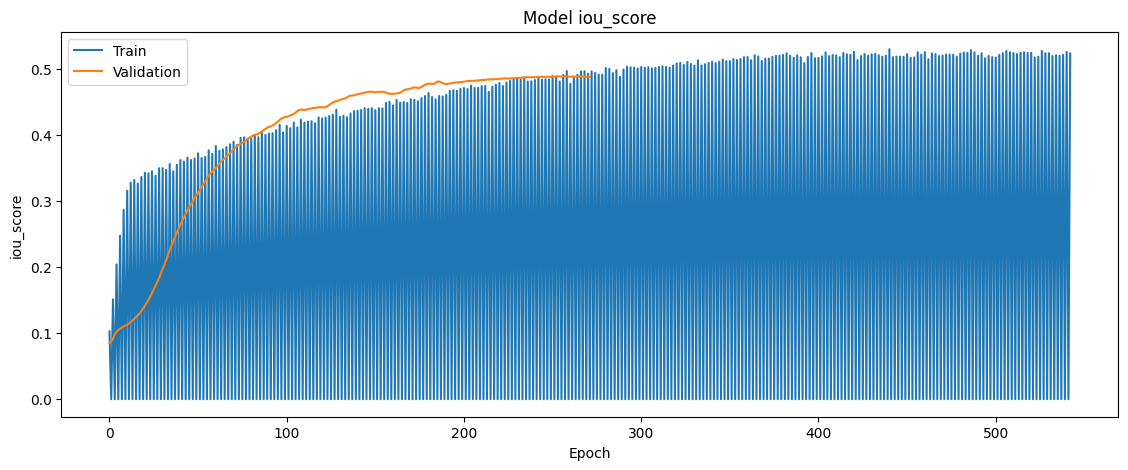

In [13]:
# Plotar valores de iou_score de treinamento e validação
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

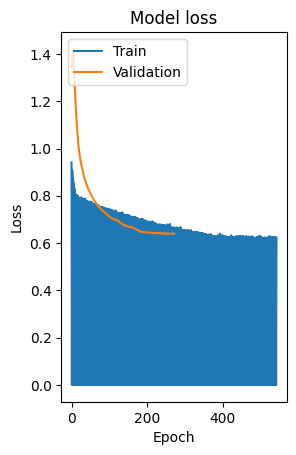

In [14]:
# Plotar valores de perda de treinamento e validação
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9398 - f1-score: 0.7047 - iou_score: 0.5447 - loss: 0.6022 - precision: 0.6402 - recall: 0.7857
Loss: 0.61648
mean iou_score: 0.52699
mean f1-score: 0.68969
mean accuracy: 0.93866
mean precision: 0.61845
mean recall: 0.78116
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


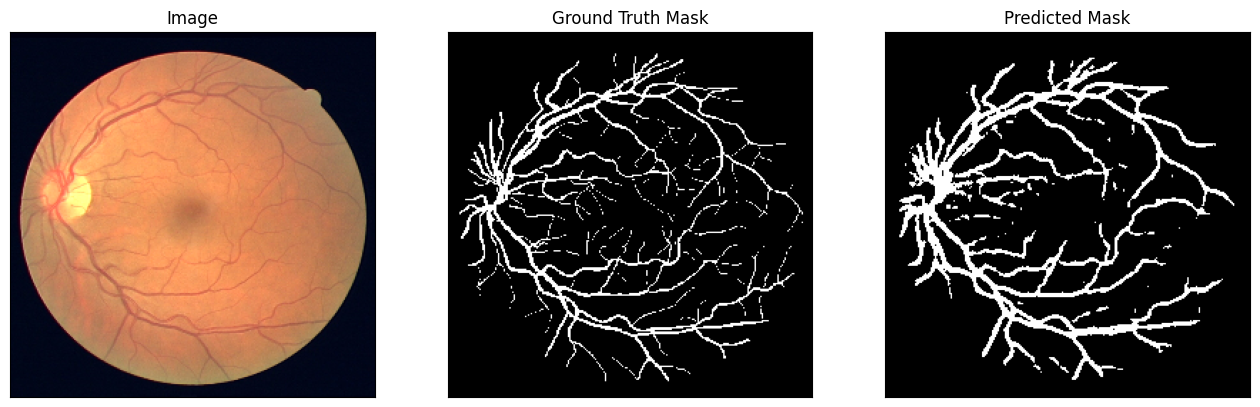

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


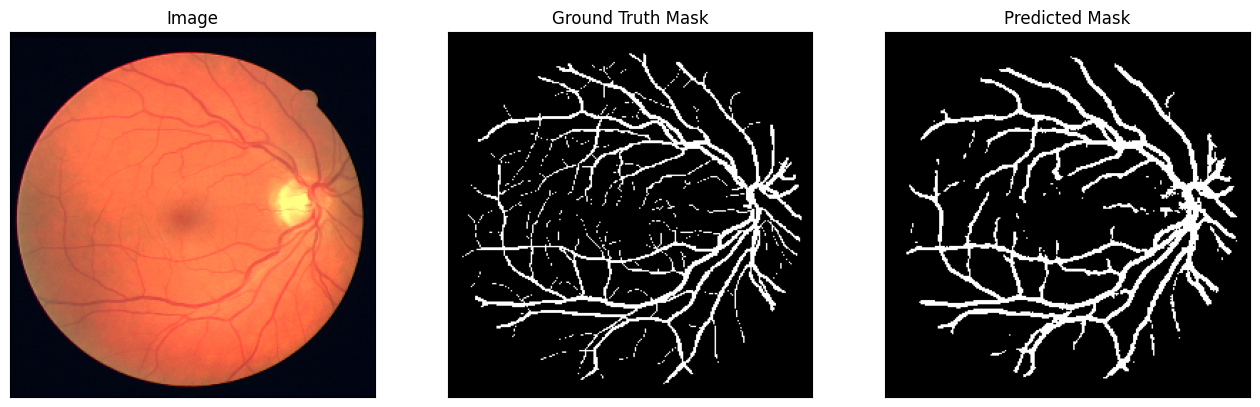

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


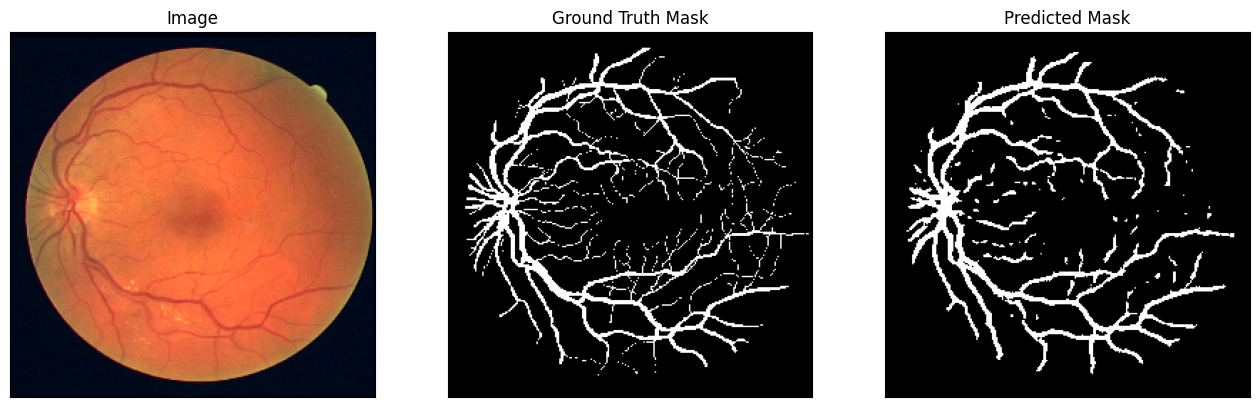

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


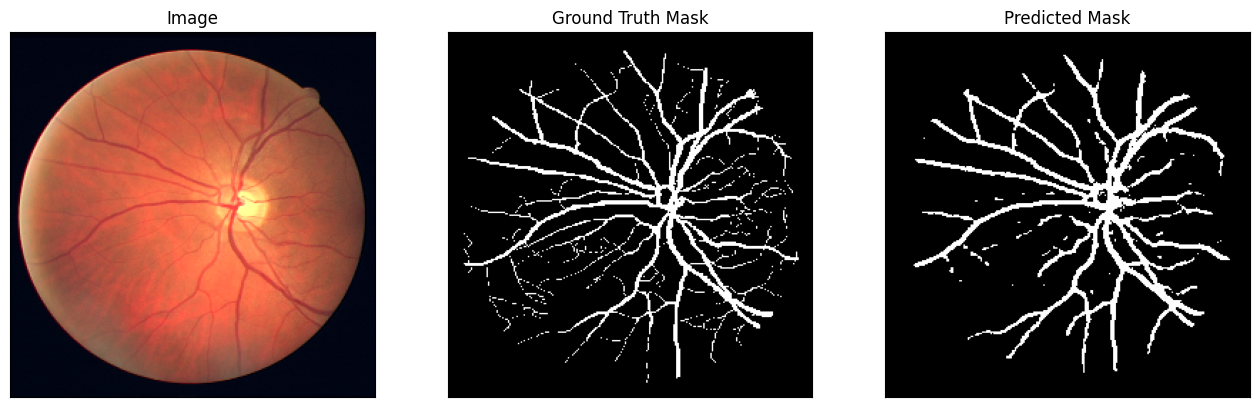

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


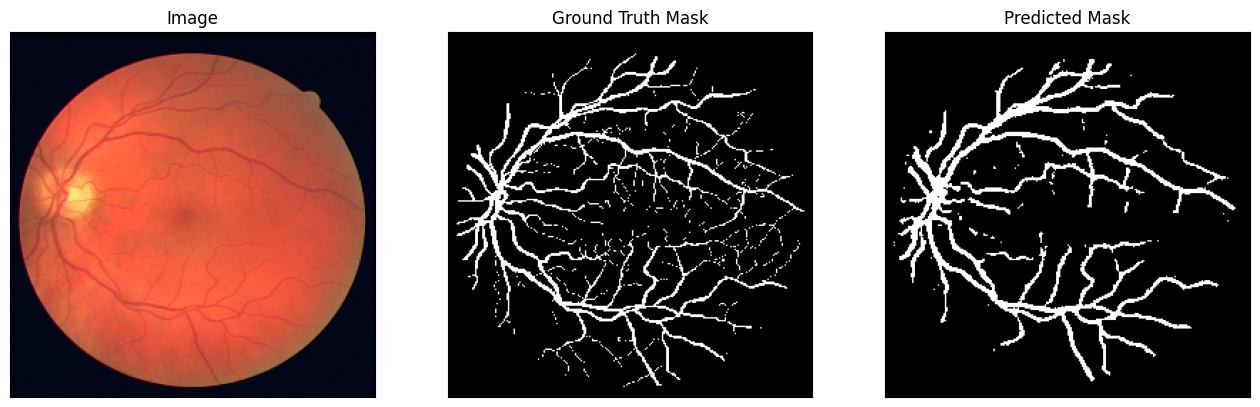

In [18]:




# # Avaliação do Modelo

# Carregar os melhores pesos
model.load_weights(model_weights)

# Avaliar no conjunto de teste
scores = model.evaluate(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__ if type(metric) != str else metric, value))

# # Visualização dos resultados no conjunto de teste

for i in range(5):
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        ground_truth_mask=gt_mask.squeeze(),
        predicted_mask=pr_mask.squeeze(),
    )